In [2]:
import os
python_test = __import__('0_python_test')
import tifffile
import pickle
from pprint import pprint
import random
from scipy import ndimage
from scipy.interpolate import interp1d
from scipy.ndimage import uniform_filter1d
import pandas as pd
import networkx as nx
import napari
import numpy as np
from napari.layers import Shapes
import matplotlib.pyplot as plt
from matplotlib import colors, cm
from PIL import Image
from tqdm import tqdm

# Part I

In [3]:
#This section is for inputting the paths to the pkls, tifs and masks that you want to analyze
#To generate the masks and pkl files needed as input here, run the scripts '1_max_create_masks.ipynb' and '4_analyse_output_radius_circle_mass_modified.ipynb', respectively

#Input your paths here
pkl_path = 'D:\\Bestun\\output_path\\ModelTest\\' #Path to the pkl files
tif_path = 'D:\\Bestun\\raw_data\\ModelTest\\' #Path to the tif files (raw data)
mask_path = 'D:\\Bestun\\masks_tracked\\ModelTest\\' #Path to the masks
export_path = 'D:\\Bestun\\plots\\' #Path to save the plots
latex_path = 'D:\\Bestun\\plots\\latex\\' #Path to save the latex tables

tif_file_path = os.path.join(tif_path, '021024_cluster_3.tif')  #Full path to the tif file
mask_file_path = os.path.join(mask_path, '021024_cluster_3.tif')    #Full path to the mask file

file_name = '021024_cluster_3' #Name of the file (without the extension)

#Set a modified list of pkls if needed
new_pkls = ['021024_cluster_3.pkl']
pkls = sorted(new_pkls)

In [4]:
#Load pkl file
for pkl in sorted(pkls):
    file_path = os.path.join(pkl_path, pkl)
    if os.path.exists(file_path):
        with open(file_path, 'rb') as f:
            d = pickle.load(f)
        print('Loaded ' + str(pkl))
    else:
        print(f"File not found: {file_path}")

Loaded 021024_cluster_3.pkl


In [5]:
# Load raw image and masks
try:
    # Load the TIFF image (raw fluorescence image)
    X = tifffile.imread(tif_file_path)
    print(f"Raw image shape: {X.shape}")
    
    # Load the corresponding mask file (segmented cell masks)
    Y = tifffile.imread(mask_file_path)
    print(f"Mask image shape: {Y.shape}")
    
    # Check if mask image and raw image match in size
    if X.shape[:2] != Y.shape[:2]:
        raise ValueError("The raw image and mask image dimensions do not match.")
    
    # Get the labels for the tracked cells (excluding the last cell)
    tracked_cells = list(d.keys())[:-1]  # Assuming 'd' contains tracked cell data
    print(f"Tracked cells: {tracked_cells}")

    # Get the unique labels in the mask image (these correspond to the different cell regions)
    unique_labels = np.unique(Y)

    # Filter the mask to keep only the regions corresponding to tracked cells
    filtered_mask = np.zeros_like(Y)  # Initialize an empty mask with the same shape as Y
    for cell_id in tracked_cells:
        if cell_id in unique_labels:
            filtered_mask[Y == cell_id] = cell_id  # Keep only the regions of tracked cells
        else:
            print(f"Warning: Cell {cell_id} not found in the mask.")

    # Create a Napari viewer
    viewer = napari.Viewer()

    # Add the raw image to the viewer
    viewer.add_image(X, name='Raw Image', colormap='gray')

    # Add the filtered mask to the viewer
    viewer.add_labels(filtered_mask, name='Filtered Masks', opacity=0.35)

    # Start the Napari viewer (this opens a GUI window for interactive visualization)
    napari.run()

except FileNotFoundError as e:
    print(f"Error loading file: {e}")
except ValueError as e:
    print(f"Error with image dimensions: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")



Raw image shape: (1441, 512, 512)
Mask image shape: (1441, 512, 512)
Tracked cells: [1, 2, 4, 7, 8, 9, 10, 12, 15, 16, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 68, 71, 136]


# Part II

In [14]:
#Here you can input your specific parameters for the analysis
#TODO: Save correlation plots for each pkl file and for window size 25
#TODO: Save the filtering plots for each pkl file and for window size 25

frame_rate = 0.2    #Frame rate of your time series (frames per second)
window_size = 25     #Window size for noise reduction in the signals (number of frames)
max_lag = 200        #Maximum time step for correlation analysis (number of frames), set based on the maximum period of oscillation observed for the smoothed signal

plot_name =  f"{file_name}_{window_size}.pdf" #Name of the .png file to save the plot as, change end depending on window size chosen
plot_file_path = os.path.join(export_path, plot_name)    #Full path to the plot file

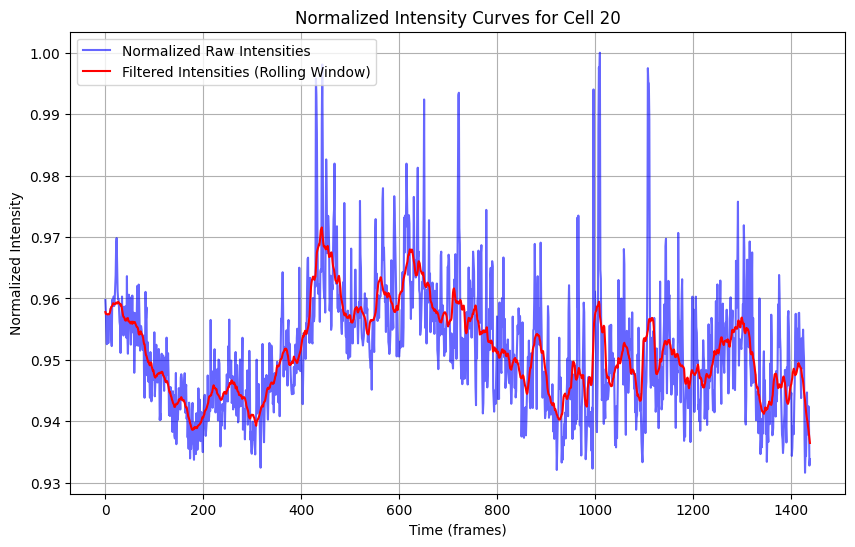

In [7]:
# Preprocessing of the intensity data

# Step 1: Normalize the intensities by dividing by the maximum intensity value for each cell
intensities_normalized = {}

# Loop through each cell in the tracked_cells list
for cell_id in tracked_cells:
    if cell_id in d:  # Ensure the cell exists in the dictionary
        cell_data = d[cell_id]
        intensities = cell_data['intensities']  # Extract the intensities

        # Normalize the intensities by dividing by the max intensity (avoid division by zero)
        max_intensity = np.max(intensities)
        if max_intensity > 0:
            normalized_intensities = intensities / max_intensity
        else:
            normalized_intensities = intensities  # If max intensity is zero, keep intensities as zero

        intensities_normalized[cell_id] = normalized_intensities  # Store the normalized intensities

# Step 2: Define rolling window average function to reduce noise with padding
def rolling_window_average_with_padding(intensities, window_size):
    """
    Apply a rolling window average to the intensity data with padding at the edges.
    
    Parameters:
    - intensities: List or np.array of intensity values.
    - window_size: The size of the rolling window (in number of frames).
    
    Returns:
    - filtered_intensities: The intensity values after applying the rolling window average.
    """
    # Pad the signal at both ends to prevent sharp transitions at the boundaries
    padded_intensities = np.pad(intensities, (window_size//2, window_size//2), mode='edge')
    
    # Apply convolution with 'same' mode after padding to maintain original length
    filtered_intensities = np.convolve(padded_intensities, np.ones(window_size)/window_size, mode='same')
    
    # Trim the filtered intensities to the original signal length
    return filtered_intensities[window_size//2: -window_size//2]

# Step 3: Apply smoothing to normalized intensities
def apply_smoothing_to_normalized(intensities_normalized, window_size, smoothing_method='padding', poly_order=3):
    filtered_intensities = {}
    
    for cell_id, intensities in intensities_normalized.items():
        if smoothing_method == 'padding':
            # Apply rolling window smoothing with padding
            filtered_intensities[cell_id] = rolling_window_average_with_padding(intensities, window_size)

    return filtered_intensities

# Smoothing of normalized intensities
filtered_intensities = apply_smoothing_to_normalized(intensities_normalized, window_size, smoothing_method='padding')

# Step 4: Plotting the normalized raw and filtered intensities for a random cell
random_cell_id = random.choice(list(intensities_normalized.keys()))  # Select a random cell ID

# Get the normalized raw intensities for the selected cell
normalized_raw_intensities = intensities_normalized[random_cell_id]  

# Get the filtered intensities (after applying rolling window or Savitzky-Golay)
filtered_intensity = filtered_intensities[random_cell_id]  

# Create a time axis based on the number of intensity values
time_axis = np.arange(len(normalized_raw_intensities))

# Ensure the time axis matches the filtered intensity length
if len(filtered_intensity) != len(time_axis):
    # Adjust time axis to match filtered intensity length
    time_axis = np.arange(len(filtered_intensity))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_axis, normalized_raw_intensities[:len(time_axis)], label='Normalized Raw Intensities', color='blue', alpha=0.6)  # Match lengths
plt.plot(time_axis, filtered_intensity, label='Filtered Intensities (Rolling Window)', color='red')
plt.title(f'Normalized Intensity Curves for Cell {random_cell_id}')
plt.xlabel('Time (frames)')
plt.ylabel('Normalized Intensity')
plt.legend()
plt.grid(True)

 # Construct the filename using the file_name and window_size
smoothing_file_name = f"{file_name}_{window_size}_smoothing.pdf"
smoothing_image_path = os.path.join(export_path, smoothing_file_name)  # Adjust path as needed

# Save the table image
plt.savefig(smoothing_image_path, bbox_inches='tight', dpi=300)  # Save with high resolution

# Display the plot
plt.show()

In [8]:
#This section calculates the correlation values between all cell pairs for the filtered intensities and lags up until the given max_lag. It also finds all the maximum correlation values for each cell pair and saves them separately.
#Custom cross-correlation function for two signals
#Uses only data points with sufficient overlap for correlation calculation

# Generate all possible pairs of cells for use in cross-correlation analysis
all_possible_pairs = [(cell1, cell2) for i, cell1 in enumerate(tracked_cells) for cell2 in tracked_cells[i+1:]]

# Initialize lists to store correlation data
all_correlations_filtered = []
max_correlations_filtered = []

# Function to calculate the cross-correlation between two cells
def get_cc(cell1, cell2, max_lag, filtered_intensities=None, min_overlap=10):
    """ Get the cross-correlation between the signals of two cells for both positive and negative time lags. 
        Excludes correlations for lags with insufficient overlap.
    """
    if max_lag <= 0:
        raise ValueError("max_lag must be a positive integer")
    
    if filtered_intensities is None:
        raise ValueError("Filtered intensities must be provided for correlation calculation")
    
    intensities1 = filtered_intensities[cell1]
    intensities2 = filtered_intensities[cell2]

    if np.any(np.isnan(intensities1)) or np.any(np.isnan(intensities2)):
        print(f"Warning: NaNs detected in intensities for cells {cell1} and {cell2}")
        return {
            'label1': cell1,
            'label2': cell2,
            'correlations': np.nan,
            'time_lags': np.arange(-max_lag, max_lag + 1, 1)
        }

    correlation_data = {
        'label1': cell1,
        'label2': cell2,
        'correlations': np.full(2 * max_lag + 1, np.nan),  # Initialize with NaN for insufficient overlaps
        'time_lags': np.arange(-max_lag, max_lag + 1, 1)
    }

    for lag in correlation_data['time_lags']:
        if lag == 0:
            num_pairs = len(intensities1)  # Entire length
            if num_pairs >= min_overlap:
                correlation_data['correlations'][max_lag] = np.mean(intensities1 * intensities2)
                if np.allclose(intensities1, intensities2):  # Identical signals
                    correlation_data['correlations'][max_lag] = 1.0
        elif lag > 0:
            product_sum = np.sum(intensities1[:-lag] * intensities2[lag:])
            num_pairs = len(intensities1) - lag
            if num_pairs >= min_overlap:
                correlation_data['correlations'][lag + max_lag] = product_sum / num_pairs
        else:
            product_sum = np.sum(intensities1[-lag:] * intensities2[:lag])
            num_pairs = len(intensities1) + lag
            if num_pairs >= min_overlap:
                correlation_data['correlations'][lag + max_lag] = product_sum / num_pairs

    return correlation_data


# Define the minimum overlap
min_overlap = 500  # Minimum number of overlapping points for correlation calculation

# Calculate correlations for each pair
for cell1, cell2 in all_possible_pairs:
    if cell1 not in filtered_intensities or cell2 not in filtered_intensities:
        print(f"Warning: Missing baseline-subtracted intensity data for cells {cell1} or {cell2}. Skipping this pair.")
        continue

    correlation_data_filtered = get_cc(cell1, cell2, max_lag, filtered_intensities=filtered_intensities, min_overlap=min_overlap)
    all_correlations_filtered.append(((cell1, cell2), correlation_data_filtered))
    max_corr_filtered = np.nanmax(correlation_data_filtered['correlations'])  # Skip NaN values
    max_correlations_filtered.append(((cell1, cell2), max_corr_filtered))


# Print the correlation values for all cell pairs from max_correlations_filtered, sorted by correlation value
print("\nAll Cell Pairs and Their Maximum Correlations:")

# Sort the max_correlations_filtered list by the correlation value (second item in the tuple)
max_correlations_filtered_sorted = sorted(max_correlations_filtered, key=lambda x: x[1], reverse=True)

for (cell1, cell2), max_corr in max_correlations_filtered_sorted:
    print(f"Cells ({cell1}, {cell2}) - Maximum Correlation: {max_corr}")


All Cell Pairs and Their Maximum Correlations:
Cells (16, 68) - Maximum Correlation: 0.9123061788254253
Cells (16, 20) - Maximum Correlation: 0.9116836769207126
Cells (15, 16) - Maximum Correlation: 0.9107719054396726
Cells (20, 68) - Maximum Correlation: 0.90893580223974
Cells (4, 16) - Maximum Correlation: 0.9083826782342601
Cells (15, 68) - Maximum Correlation: 0.907994121268397
Cells (15, 20) - Maximum Correlation: 0.907431343983359
Cells (4, 68) - Maximum Correlation: 0.905697766438927
Cells (4, 15) - Maximum Correlation: 0.9042064520495782
Cells (4, 20) - Maximum Correlation: 0.9027702794017097
Cells (7, 16) - Maximum Correlation: 0.900575318420359
Cells (7, 68) - Maximum Correlation: 0.8978582013864892
Cells (16, 34) - Maximum Correlation: 0.8970407913811429
Cells (12, 16) - Maximum Correlation: 0.8965043410020855
Cells (16, 28) - Maximum Correlation: 0.8964652131597197
Cells (7, 15) - Maximum Correlation: 0.8964109015663575
Cells (34, 68) - Maximum Correlation: 0.8957179918228

In [9]:
#This section calculates the maximum and minimum correlation values for each cell pair and saves them in a table for visualization

# Generate all possible pairs of cells for use in cross-correlation analysis
all_possible_pairs = [(cell1, cell2) for i, cell1 in enumerate(tracked_cells) for cell2 in tracked_cells[i+1:]]

# Initialize lists to store correlation data
all_correlations_filtered = []
max_correlations_filtered = []
min_correlations_filtered = []

# Function to calculate the cross-correlation between two cells
def get_cc(cell1, cell2, max_lag, filtered_intensities=None, min_overlap=10):
    """ Get the cross-correlation between the signals of two cells for both positive and negative time lags. 
        Excludes correlations for lags with insufficient overlap.
    """
    if max_lag <= 0:
        raise ValueError("max_lag must be a positive integer")
    
    if filtered_intensities is None:
        raise ValueError("Filtered intensities must be provided for correlation calculation")
    
    intensities1 = filtered_intensities[cell1]
    intensities2 = filtered_intensities[cell2]

    if np.any(np.isnan(intensities1)) or np.any(np.isnan(intensities2)):
        print(f"Warning: NaNs detected in intensities for cells {cell1} and {cell2}")
        return {
            'label1': cell1,
            'label2': cell2,
            'correlations': np.nan,
            'time_lags': np.arange(-max_lag, max_lag + 1, 1)
        }

    correlation_data = {
        'label1': cell1,
        'label2': cell2,
        'correlations': np.full(2 * max_lag + 1, np.nan),  # Initialize with NaN for insufficient overlaps
        'time_lags': np.arange(-max_lag, max_lag + 1, 1)
    }

    for lag in correlation_data['time_lags']:
        if lag == 0:
            num_pairs = len(intensities1)  # Entire length
            if num_pairs >= min_overlap:
                correlation_data['correlations'][max_lag] = np.mean(intensities1 * intensities2)
                if np.allclose(intensities1, intensities2):  # Identical signals
                    correlation_data['correlations'][max_lag] = 1.0
        elif lag > 0:
            product_sum = np.sum(intensities1[:-lag] * intensities2[lag:])
            num_pairs = len(intensities1) - lag
            if num_pairs >= min_overlap:
                correlation_data['correlations'][lag + max_lag] = product_sum / num_pairs
        else:
            product_sum = np.sum(intensities1[-lag:] * intensities2[:lag])
            num_pairs = len(intensities1) + lag
            if num_pairs >= min_overlap:
                correlation_data['correlations'][lag + max_lag] = product_sum / num_pairs

    return correlation_data


# Define the minimum overlap
min_overlap = 500  # Minimum number of overlapping points for correlation calculation

# Calculate correlations for each pair
for cell1, cell2 in all_possible_pairs:
    if cell1 not in filtered_intensities or cell2 not in filtered_intensities:
        print(f"Warning: Missing baseline-subtracted intensity data for cells {cell1} or {cell2}. Skipping this pair.")
        continue

    correlation_data_filtered = get_cc(cell1, cell2, max_lag, filtered_intensities=filtered_intensities, min_overlap=min_overlap)
    all_correlations_filtered.append(((cell1, cell2), correlation_data_filtered))
    
    # Get the maximum and minimum correlation values, skipping NaNs
    max_corr_filtered = np.nanmax(correlation_data_filtered['correlations'])  # Maximum correlation value
    min_corr_filtered = np.nanmin(correlation_data_filtered['correlations'])  # Minimum correlation value
    
    max_correlations_filtered.append(((cell1, cell2), max_corr_filtered))
    min_correlations_filtered.append(((cell1, cell2), min_corr_filtered))


# Print the correlation values for all cell pairs: maximum, minimum
print("\nAll Cell Pairs and Their Maximum and Minimum Correlations:")

# Sort the max_correlations_filtered list by the maximum correlation value (second item in the tuple)
max_correlations_filtered_sorted = sorted(max_correlations_filtered, key=lambda x: x[1], reverse=True)
min_correlations_filtered_sorted = sorted(min_correlations_filtered, key=lambda x: x[1])

# Print the maximum correlation values
print("\nMaximum Correlations:")
for (cell1, cell2), max_corr in max_correlations_filtered_sorted:
    print(f"Cells ({cell1}, {cell2}) - Maximum Correlation: {max_corr}")

# Print the minimum correlation values
print("\nMinimum Correlations:")
for (cell1, cell2), min_corr in min_correlations_filtered_sorted:
    print(f"Cells ({cell1}, {cell2}) - Minimum Correlation: {min_corr}")


#This section creates a table with the top 10 and bottom 10 cell pairs based on the maximum correlation values

# Sort max correlations (in descending order) based on the maximum correlation values
max_correlations_filtered_sorted = sorted(max_correlations_filtered, key=lambda x: x[1], reverse=True)

# Select the top 10 and bottom 10 cell pairs based on maximum correlation values
top_10_pairs = max_correlations_filtered_sorted[:10]  # Top 10 pairs
bottom_10_pairs = max_correlations_filtered_sorted[-10:]  # Bottom 10 pairs

# Function to create and save the table for a list of pairs
def create_and_save_table(pairs, table_title, file_name):
    # Populate the table data with the selected cell pairs, their max and min correlation values
    table_data = []
    for (cell1, cell2), max_corr in pairs:
        # Find the corresponding minimum correlation for the same cell pair
        min_corr = next(min_corr_value for (c1, c2), min_corr_value in min_correlations_filtered if c1 == cell1 and c2 == cell2)
        table_data.append([cell1, cell2, max_corr, min_corr])

    # Create a matplotlib figure
    fig, ax = plt.subplots(figsize=(10, len(table_data) * 0.5))  # Set size based on the number of rows

    # Hide the axes
    ax.axis('off')

    # Create a table using matplotlib
    table = ax.table(cellText=table_data,
                     colLabels=['Cell 1', 'Cell 2', 'Max Correlation', 'Min Correlation'],
                     cellLoc='center',
                     loc='center')

    # Style the table (optional)
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    # Construct the filename using the file_name, table title, and clean the title for the file system
    table_file_name = f"{file_name}_{table_title.replace(' ', '_').replace(',', '')}.png"
    table_image_path = os.path.join(export_path, table_file_name)  # Adjust path as needed
    
    # Save the table image
    plt.savefig(table_image_path, bbox_inches='tight', dpi=300)  # Save with high resolution

    # Show the plot (optional, for previewing in an interactive environment)
    plt.show()

    # Optionally, print the file path
    print(f"{table_title} saved as: {table_image_path}")

def generate_latex_table(pairs, title, label, file_name):
    """
    Generates a LaTeX table for given cell correlation pairs and saves it to a file.
    """
    latex_table = rf"""\begin{{table}}[H]
\centering
\caption{{{f"{file_name.replace('_', ' ').replace('c', 'C')} - {title}"}}}
    \begin{{tabularx}}{{\textwidth}}{{CCCC}}
    \toprule[0.5pt]\toprule[0.5pt]\toprule[0.5pt]
    \multicolumn{{1}}{{C}}{{\itshape Cell 1}} &
    \multicolumn{{1}}{{C}}{{\itshape Cell 2}} &
    \multicolumn{{1}}{{C}}{{\itshape\makecell[C]{{Max\\Correlation}}}} &
    \multicolumn{{1}}{{C}}{{\itshape\makecell[C]{{Min\\Correlation}}}}\\
    \midrule[0.5pt]\midrule[0.5pt]
"""
    
    for idx, ((cell1, cell2), max_corr) in enumerate(pairs):
        min_corr = next(min_corr_value for (c1, c2), min_corr_value in min_correlations_filtered if c1 == cell1 and c2 == cell2)
        
        # Append the row, but only add "\n" if it's not the last row
        latex_table += f"        \\multicolumn{{1}}{{T}}{{{cell1}}} &\n        \\multicolumn{{1}}{{T}}{{{cell2}}} &\n        \\multicolumn{{1}}{{T}}{{{max_corr:.4f}}} &\n        \\multicolumn{{1}}{{T}}{{{min_corr:.4f}}}"
        if idx < len(pairs) - 1:  # Not the last row
            latex_table += " \\\\ \n        \\midrule\n"
        else:  # Last row, no newline
            latex_table += " \\\\"

    latex_table += rf"""
    \midrule[0.5pt]\midrule[0.5pt]\midrule[0.5pt]
    \end{{tabularx}}
\label{{tab:{label}}}
\end{{table}}"""
    
    latex_file_name = f"{file_name}_{title.replace(' ', '_')}.tex"
    latex_file_path = os.path.join(latex_path, latex_file_name)
    
    with open(latex_file_path, "w") as file:
        file.write(latex_table)
    
    print(f"LaTeX table saved at: {latex_file_path}")

# Create and save the table for the top 10 and bottom 10 correlations
# create_and_save_table(top_10_pairs, "Top 10 Highest Correlations", file_name)
# create_and_save_table(bottom_10_pairs, "Bottom 10 Lowest Correlations", file_name)

# Generate and save LaTeX tables for top 10 and bottom 10 correlations
generate_latex_table(top_10_pairs, "Top 10 Highest Correlations", f"{file_name}_correlationTableTop10", file_name)
generate_latex_table(bottom_10_pairs, "Bottom 10 Lowest Correlations", f"{file_name}_correlationTableBottom10", file_name)


All Cell Pairs and Their Maximum and Minimum Correlations:

Maximum Correlations:
Cells (16, 68) - Maximum Correlation: 0.9123061788254253
Cells (16, 20) - Maximum Correlation: 0.9116836769207126
Cells (15, 16) - Maximum Correlation: 0.9107719054396726
Cells (20, 68) - Maximum Correlation: 0.90893580223974
Cells (4, 16) - Maximum Correlation: 0.9083826782342601
Cells (15, 68) - Maximum Correlation: 0.907994121268397
Cells (15, 20) - Maximum Correlation: 0.907431343983359
Cells (4, 68) - Maximum Correlation: 0.905697766438927
Cells (4, 15) - Maximum Correlation: 0.9042064520495782
Cells (4, 20) - Maximum Correlation: 0.9027702794017097
Cells (7, 16) - Maximum Correlation: 0.900575318420359
Cells (7, 68) - Maximum Correlation: 0.8978582013864892
Cells (16, 34) - Maximum Correlation: 0.8970407913811429
Cells (12, 16) - Maximum Correlation: 0.8965043410020855
Cells (16, 28) - Maximum Correlation: 0.8964652131597197
Cells (7, 15) - Maximum Correlation: 0.8964109015663575
Cells (34, 68) - M

In [10]:
#This section finds the significant threshold for the correlation values by shuffling the intensities and comparing the observed correlation values to the null distribution. This threshold is then used in the rest 
#of the analysis to find significant correlations.

# Sort the list in ascending order for threshold computation
max_correlations_filtered_sorted_asc = sorted(max_correlations_filtered, key=lambda x: x[1])

# Function to compute the null distribution
def compute_null_distribution(all_possible_pairs, filtered_intensities, max_lag, num_permutations=1000):
    """
    Compute the null distribution of maximum correlations by shuffling intensities.
    
    Args:
    - all_possible_pairs: List of all possible pairs of cells
    - filtered_intensities: Dictionary containing the filtered intensity data for each cell
    - max_lag: Maximum time lag for cross-correlation
    - num_permutations: Number of permutations to generate null distribution
    
    Returns:
    - null_distribution: Flattened list of maximum correlation values from shuffled data
    """
    null_distribution = []
    for _ in tqdm(range(num_permutations), desc="Computing Null Distribution", ncols=100, unit="perm"):
        # Shuffle intensities for all cells
        shuffled_intensities = {cell: np.random.permutation(intensity) for cell, intensity in filtered_intensities.items()}
        # Calculate correlations for all pairs using shuffled data
        for cell1, cell2 in all_possible_pairs:
            shuffled_corr = get_cc(cell1, cell2, max_lag, filtered_intensities=shuffled_intensities)
            max_corr = np.max(shuffled_corr['correlations'])
            null_distribution.append(max_corr)
    return np.array(null_distribution)

# Function to find significant correlation threshold
def find_significant_threshold_optimized(
    max_correlations_filtered_sorted_asc,  # List of max correlations sorted in ascending order, 
    null_distribution,
    p_value_threshold=0.05
):
    """
    Efficiently find the correlation threshold where the p-value falls below the specified p-value threshold.
    
    Args:
    - max_correlations_filtered_sorted_asc: List of max correlations sorted in ascending order
    - null_distribution: Flattened array of maximum correlation values from shuffled data
    - p_value_threshold: The p-value threshold to find (default 0.05)
    
    Returns:
    - threshold: The correlation threshold where p-value < p_value_threshold
    - p_value: The p-value at the found threshold
    """
    # Iterate over the sorted list of maximum correlations in ascending order
    for _, correlation in max_correlations_filtered_sorted_asc:  # _ is used for the pair that is not needed
        # Calculate the p-value: how often is the observed correlation greater than or equal to values in the null distribution?
        p_value = np.mean(null_distribution >= correlation)  # Compare the observed correlation to the null distribution
        
        # If p-value is below the threshold, return the correlation value and the p-value
        if p_value < p_value_threshold:
            print(f"Significant correlation threshold found: {correlation} (p-value: {p_value})")
            return correlation, p_value
    
    # If no significant threshold is found
    print("No significant correlation threshold found with p-value below the threshold.")
    return None, None


# Compute the null distribution
null_distribution = compute_null_distribution(all_possible_pairs, filtered_intensities, max_lag, num_permutations=1000)

# Execute the significance test to find the threshold and its corresponding p-value
significant_threshold, significant_p_value = find_significant_threshold_optimized(
    max_correlations_filtered_sorted_asc=max_correlations_filtered_sorted_asc,
    null_distribution=null_distribution,
    p_value_threshold=0.05
)

#Set the significant threshold as the threshold to be used for the rest of the analysis
threshold = significant_threshold

Computing Null Distribution: 100%|████████████████████████████| 1000/1000 [25:10<00:00,  1.51s/perm]


Significant correlation threshold found: 0.8913107106961414 (p-value: 0.0488125)


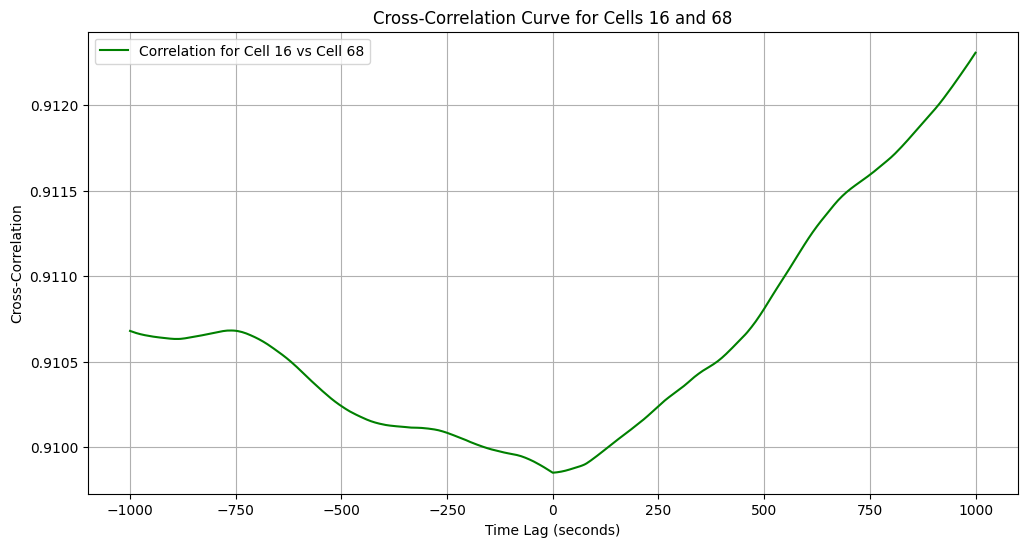

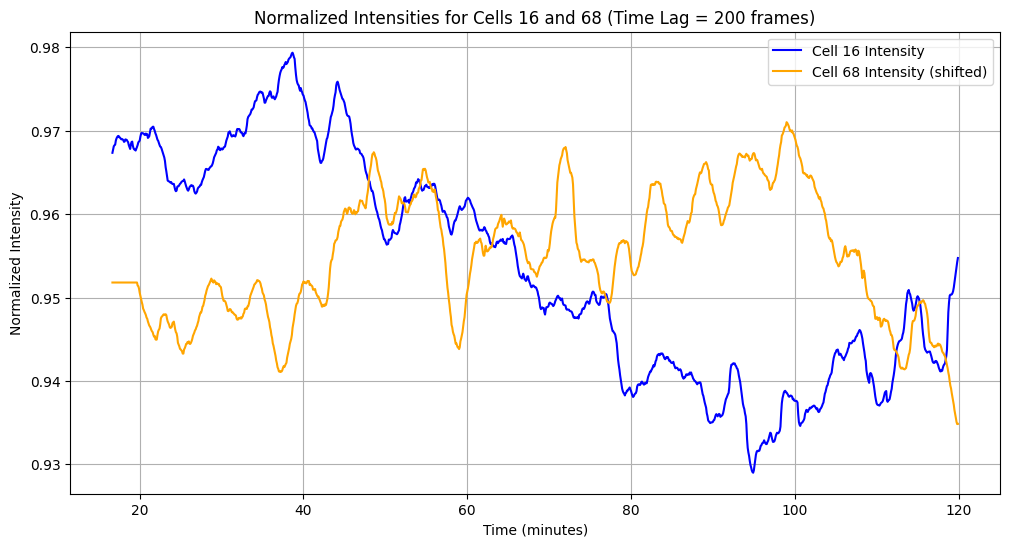

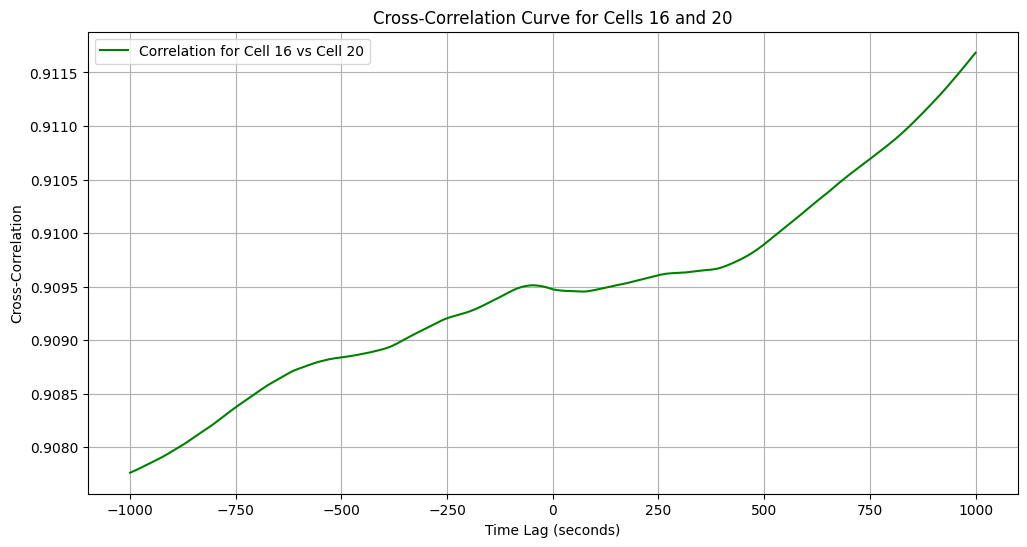

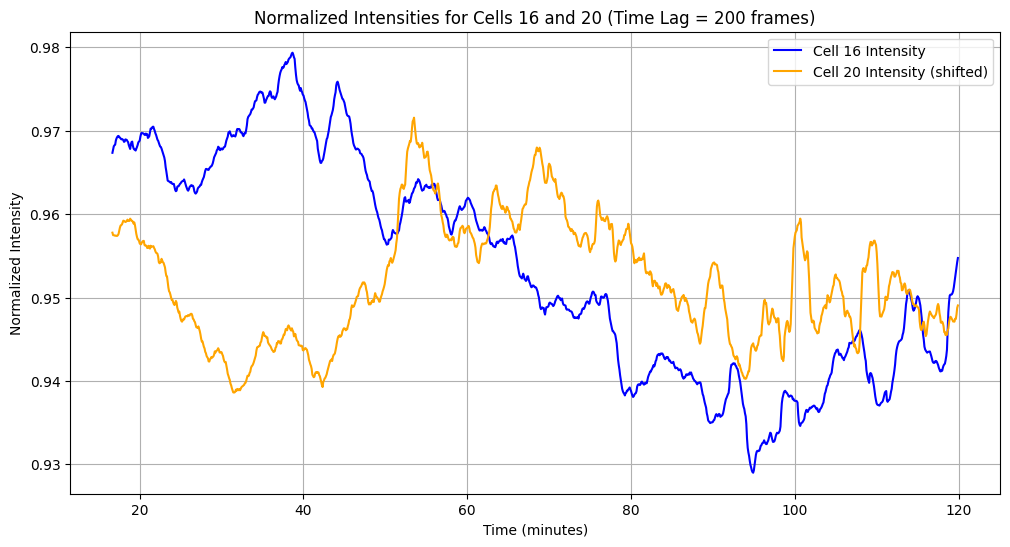

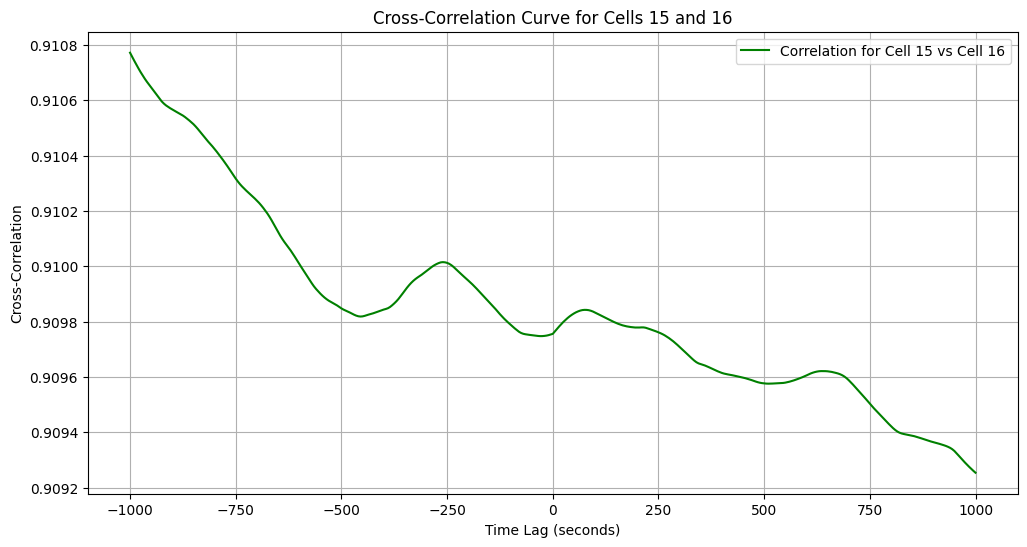

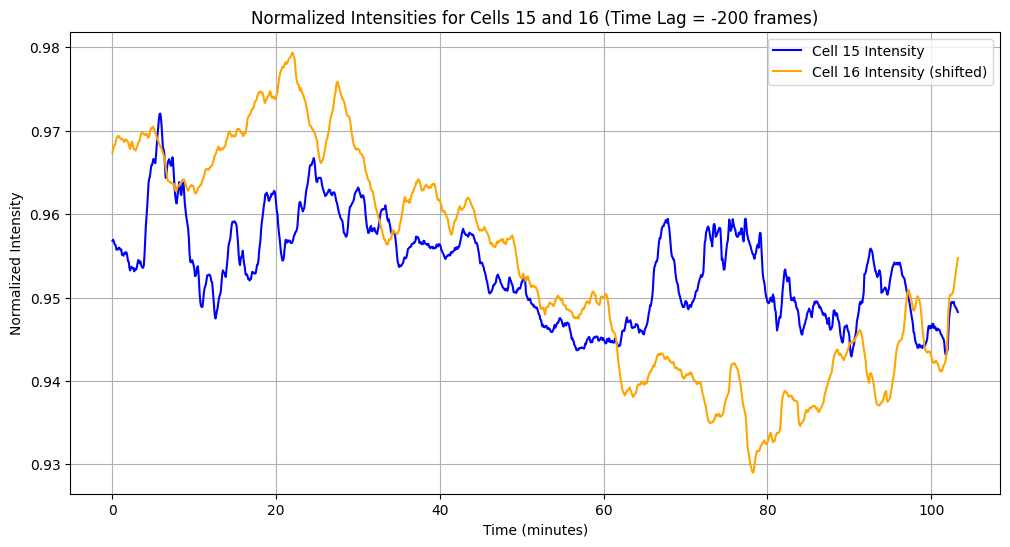

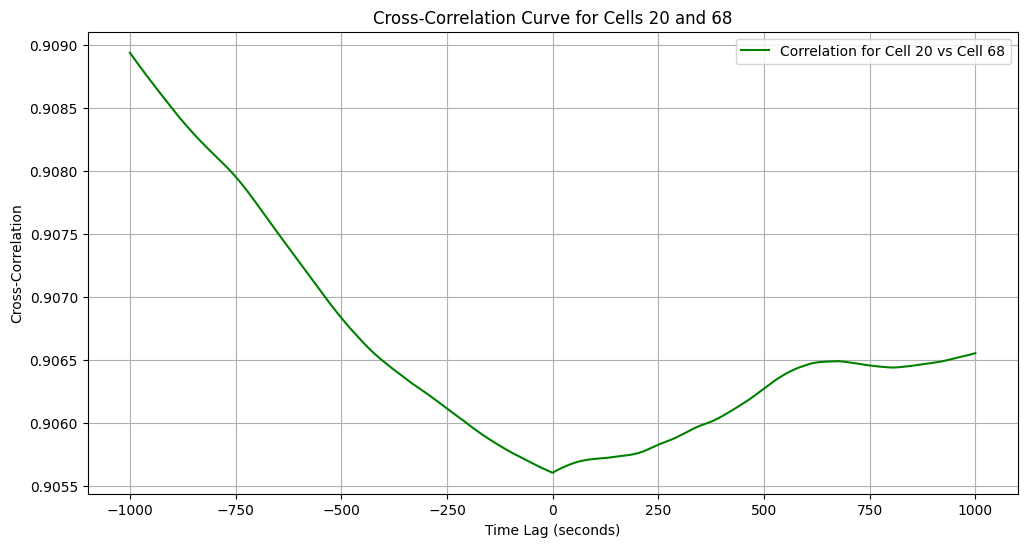

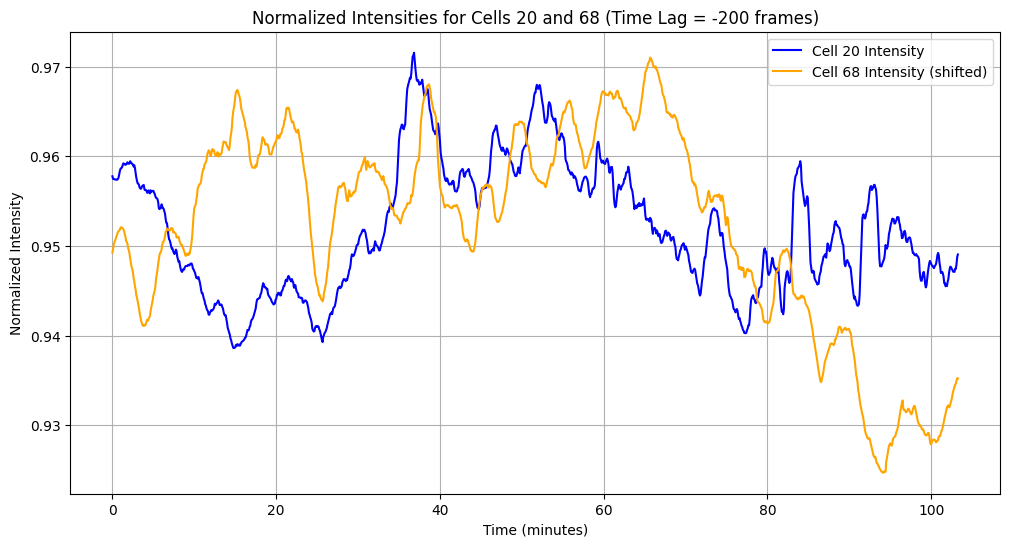

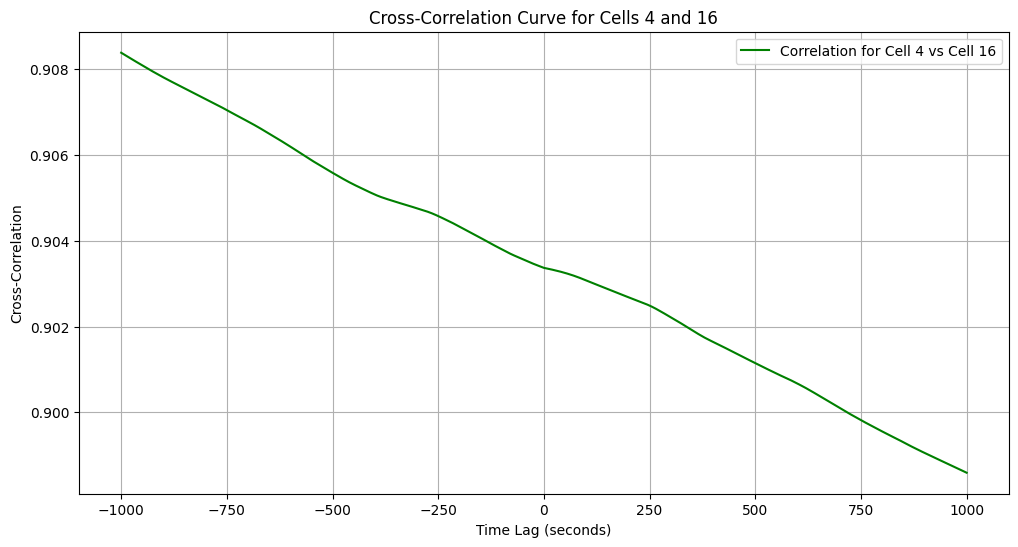

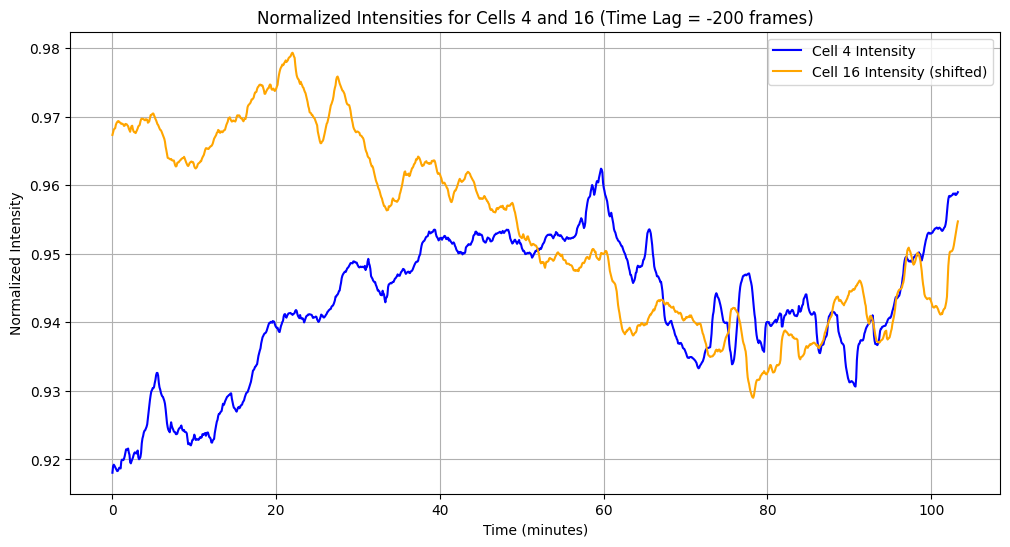

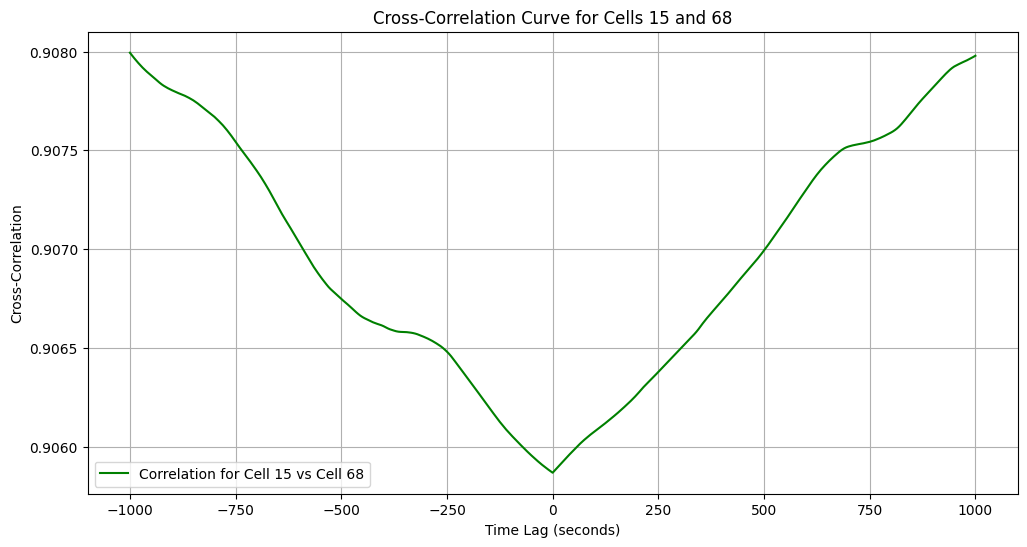

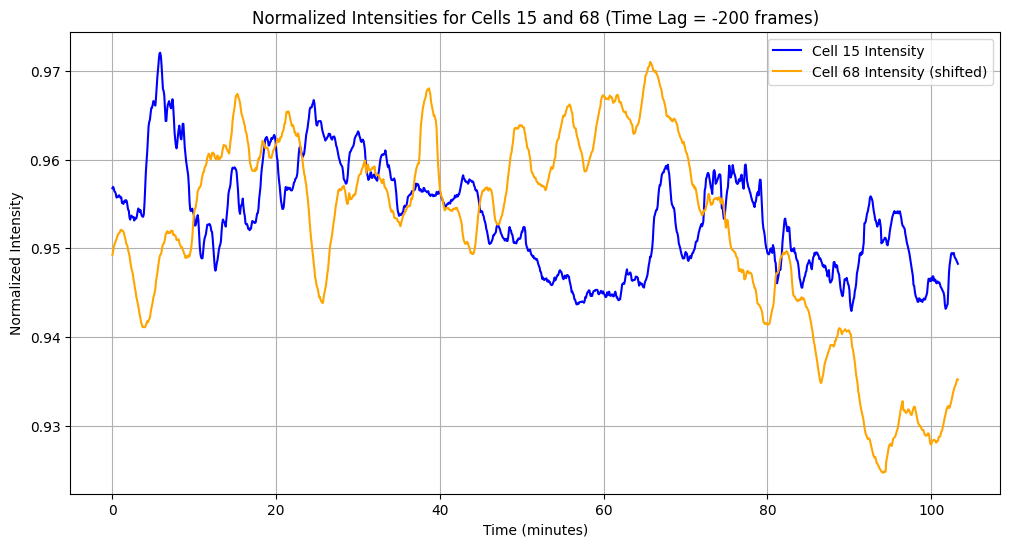

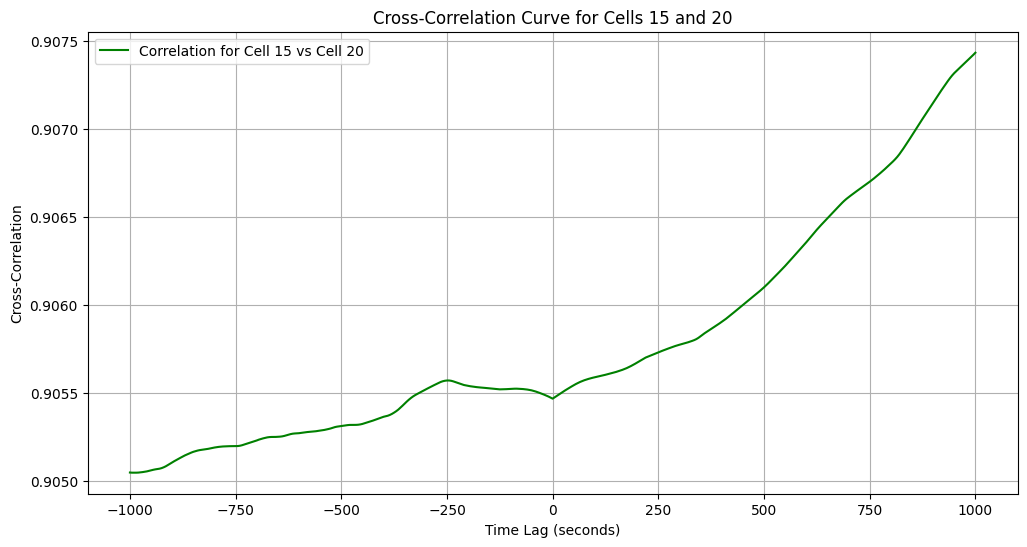

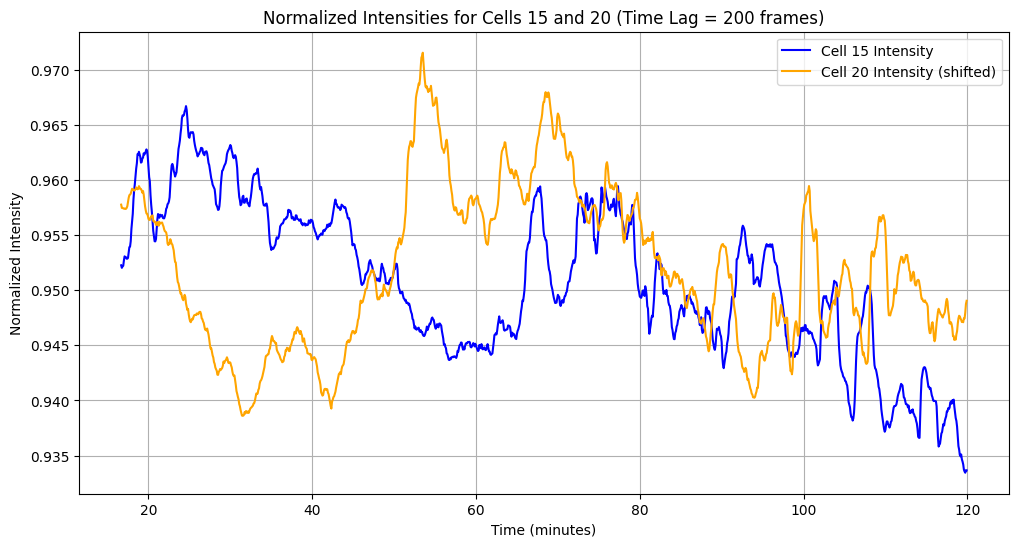

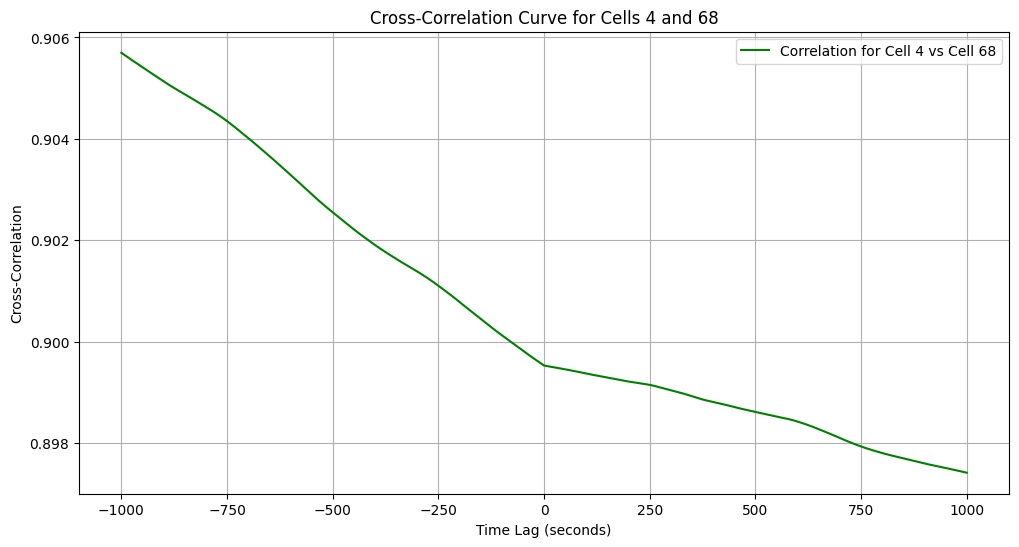

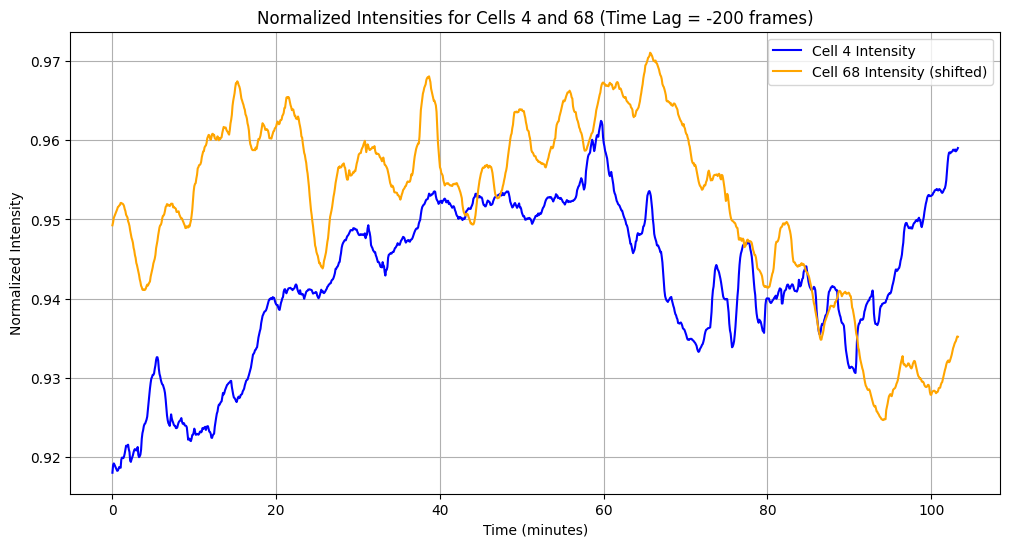

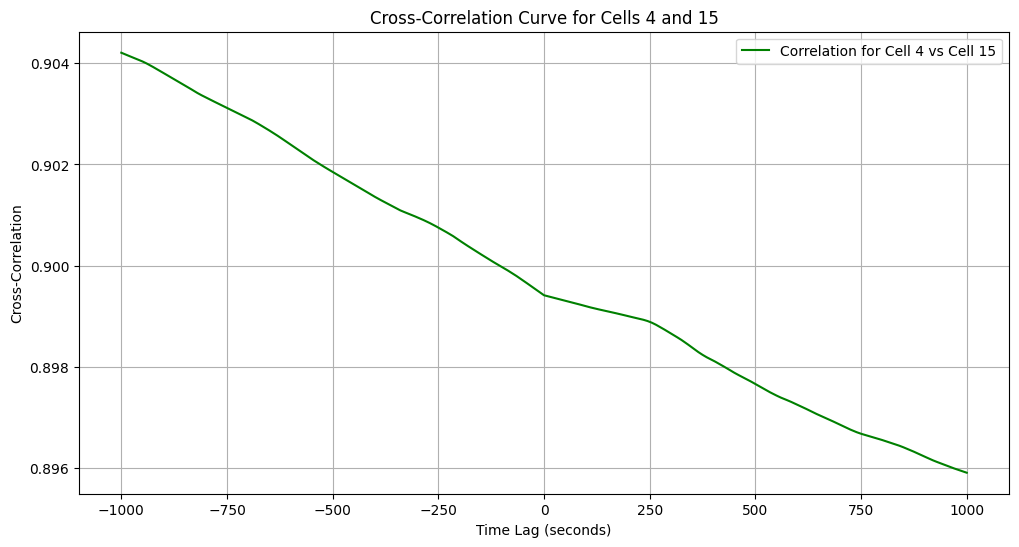

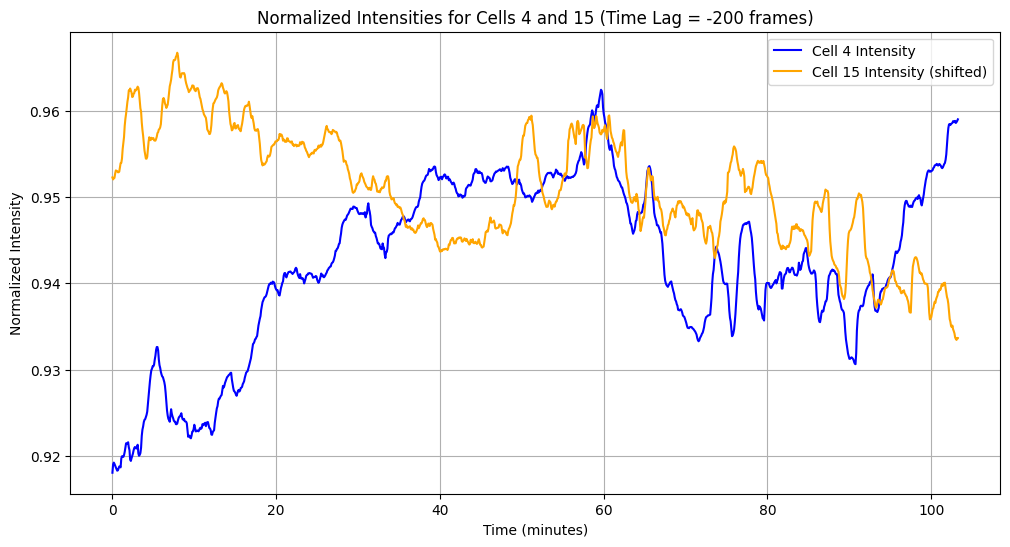

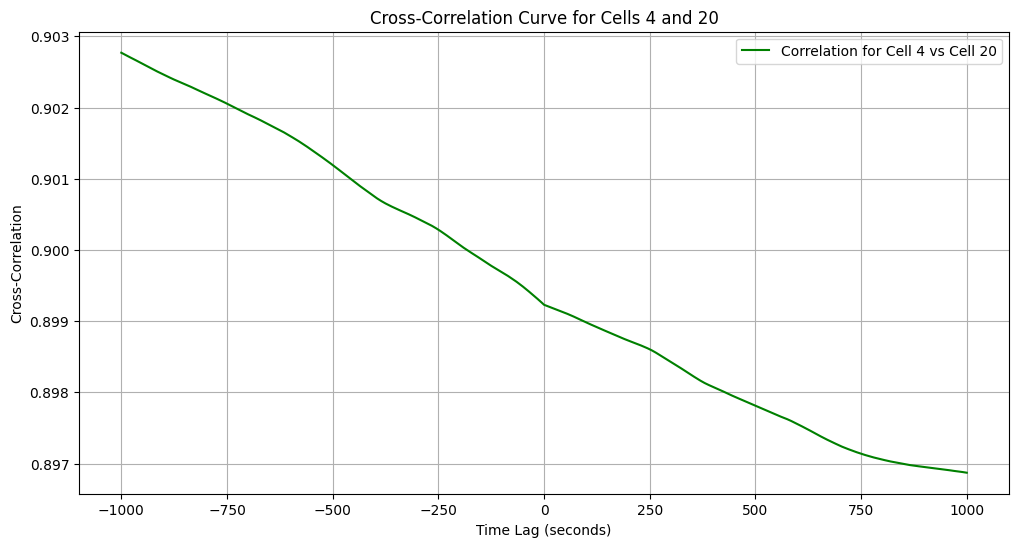

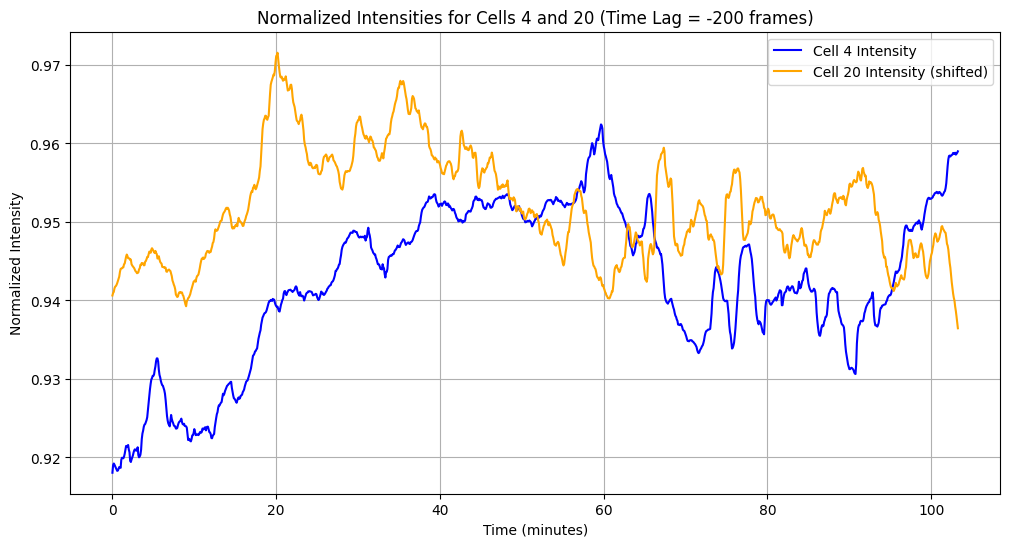

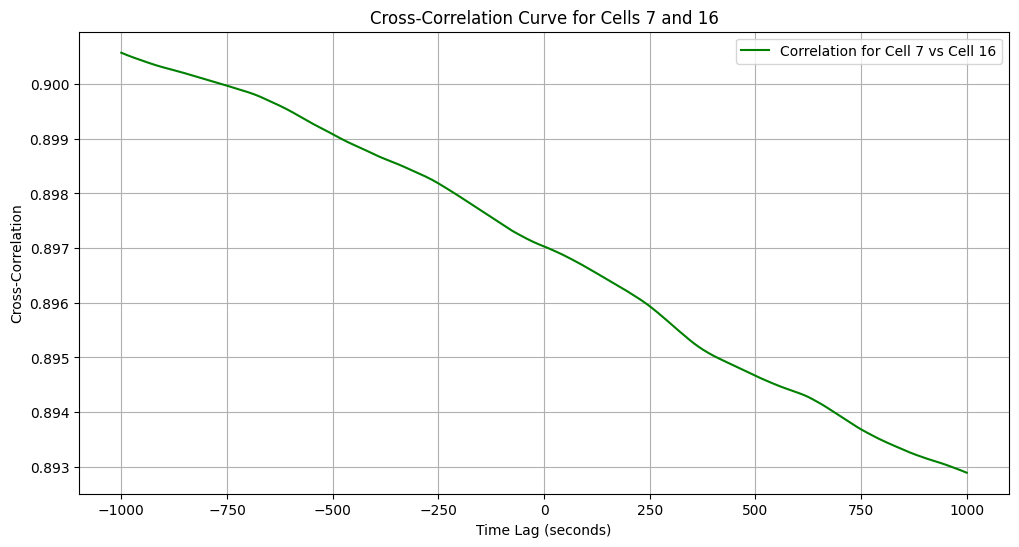

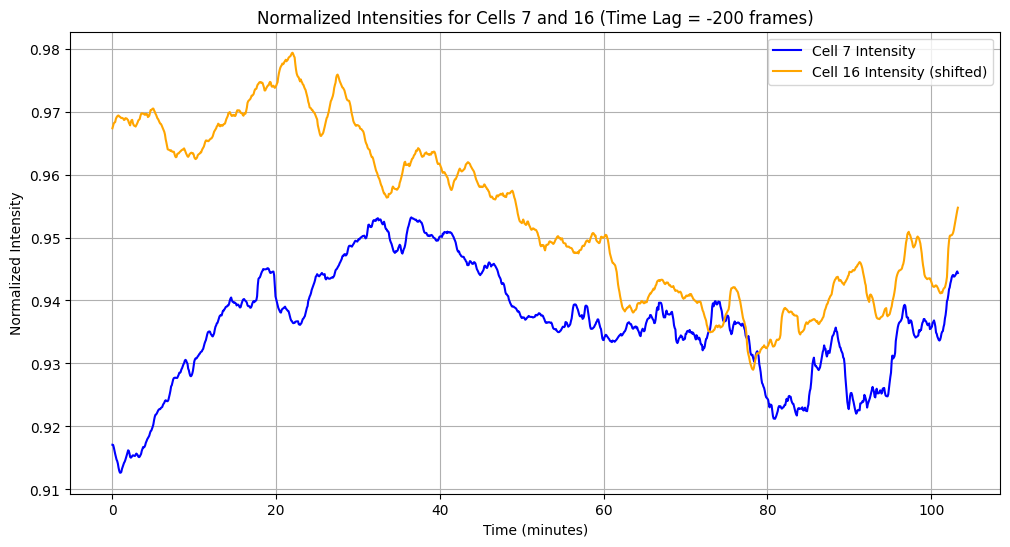

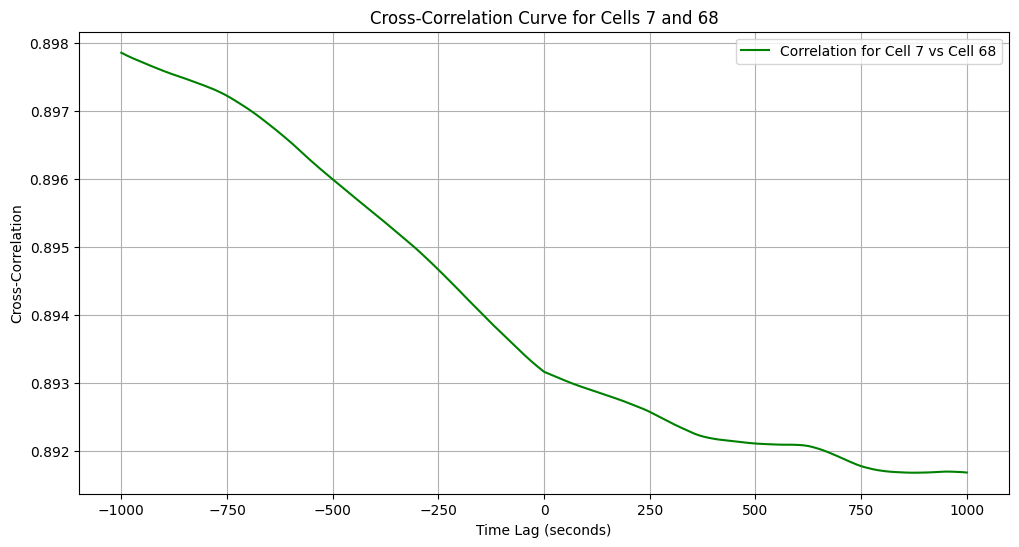

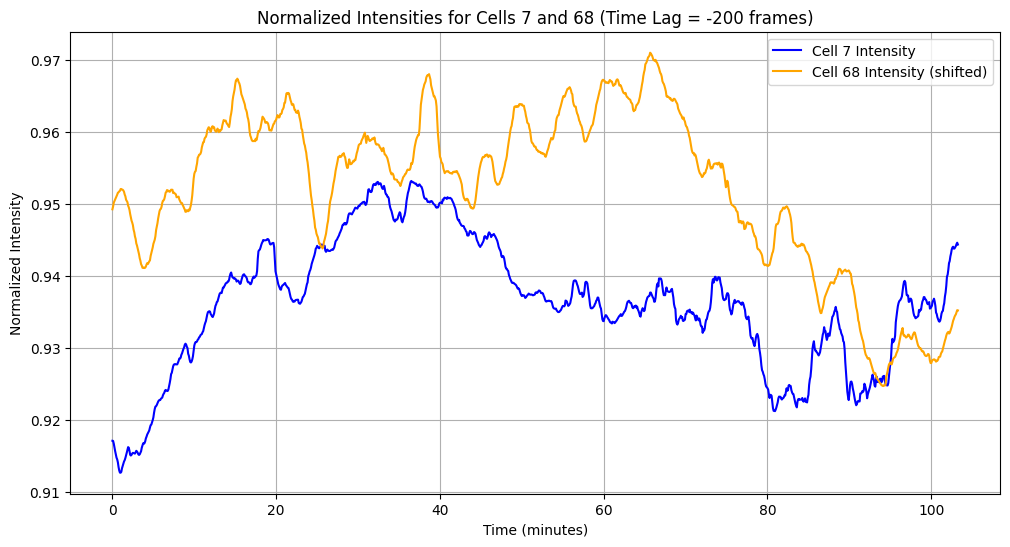

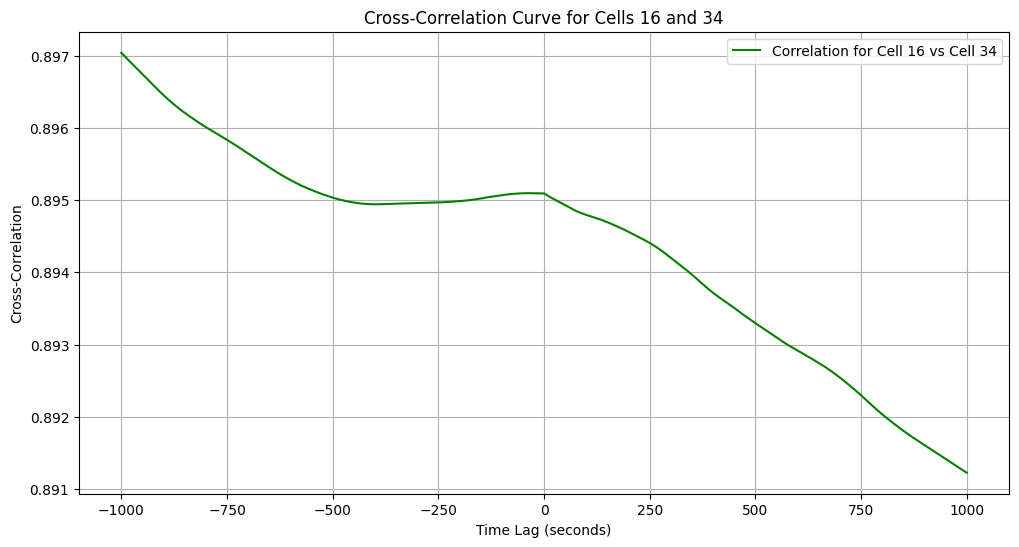

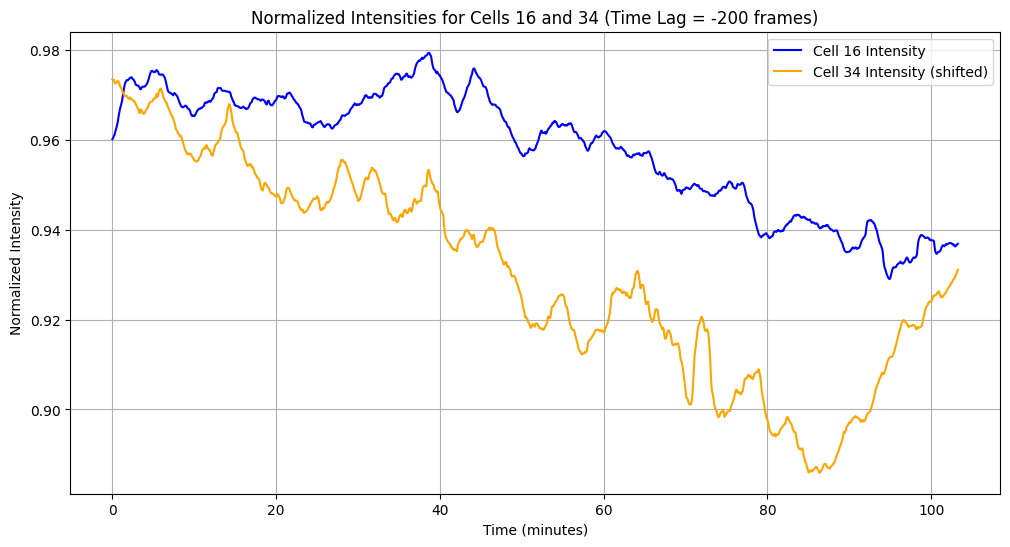

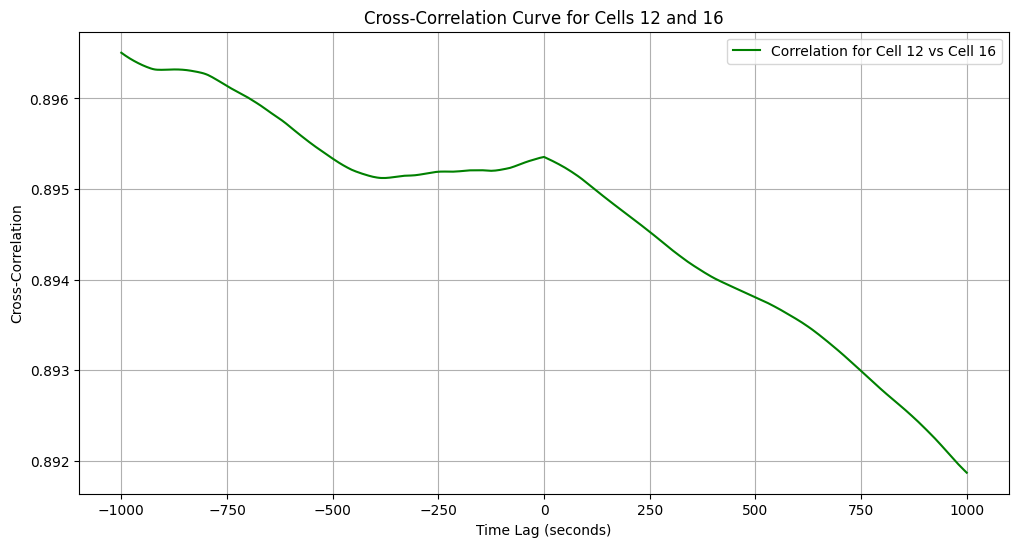

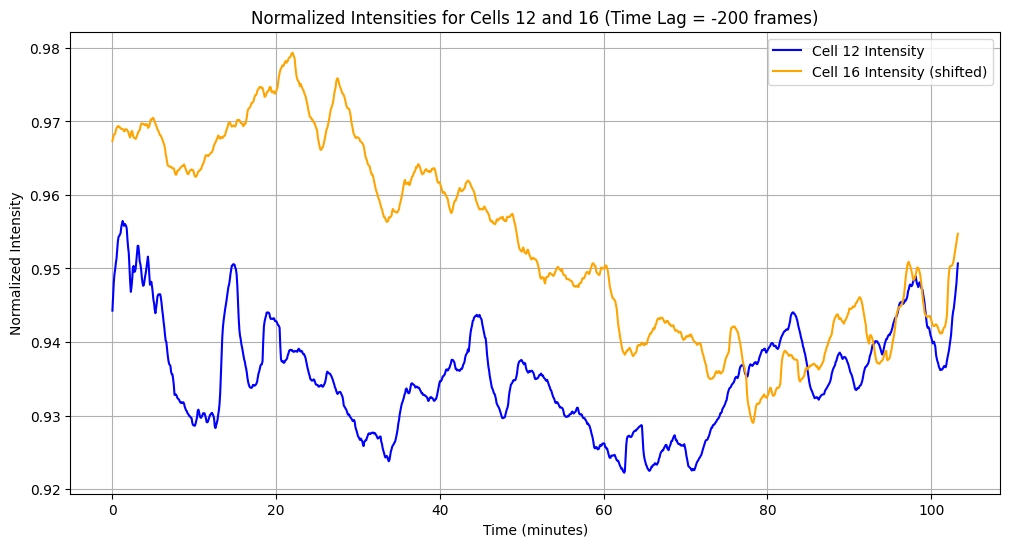

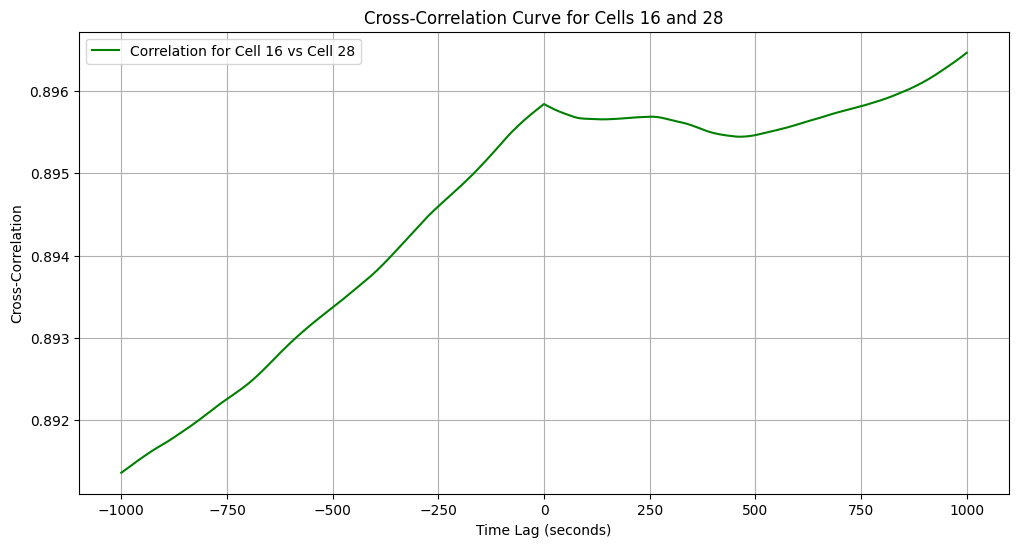

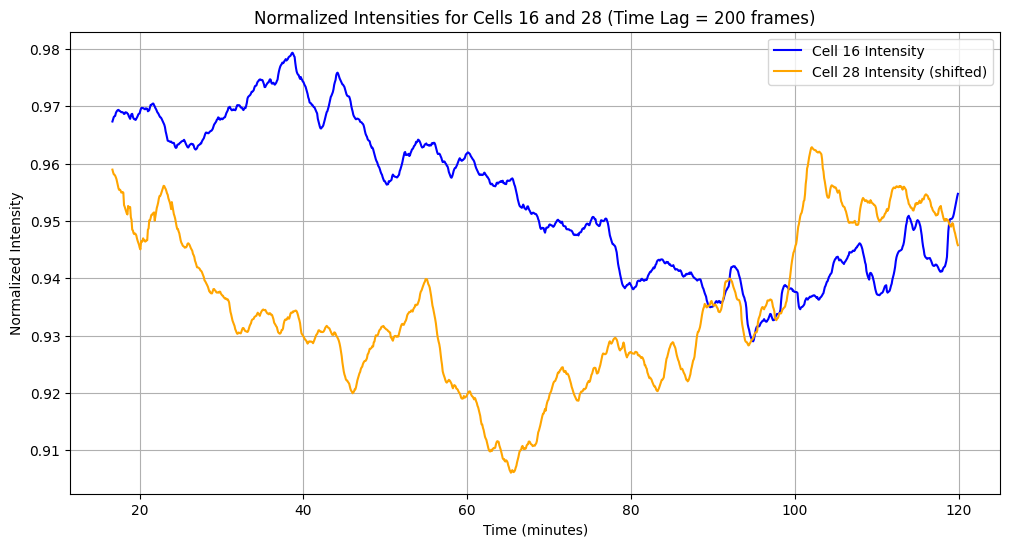

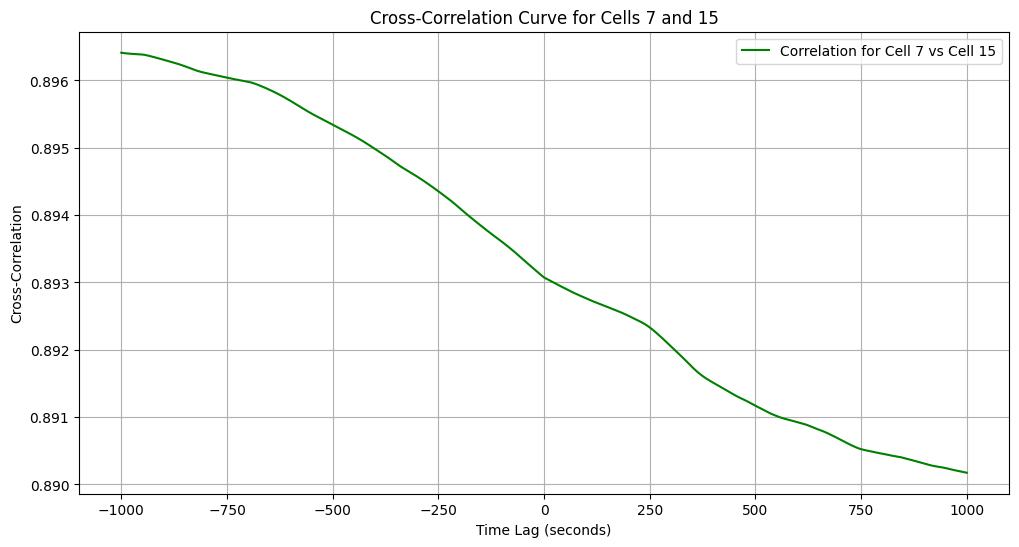

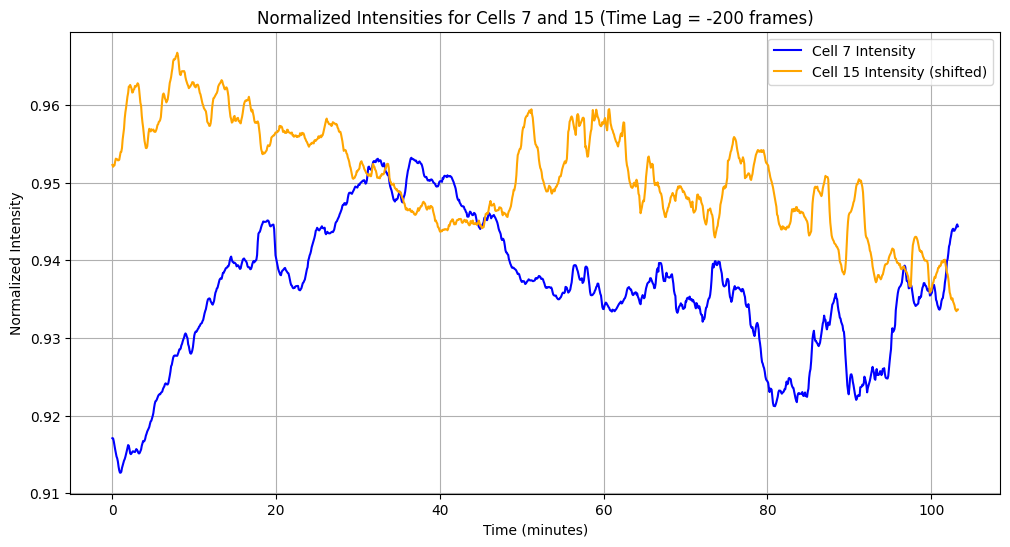

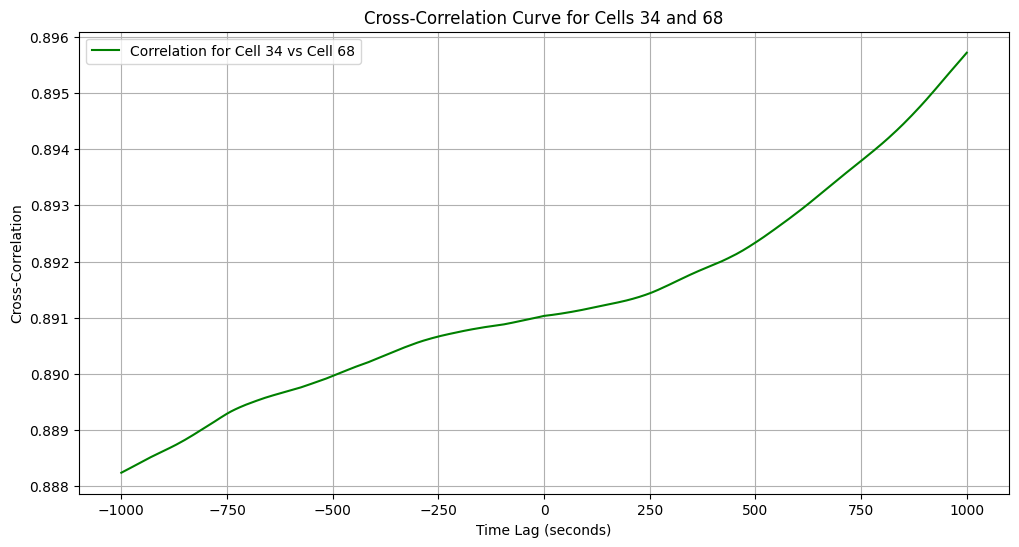

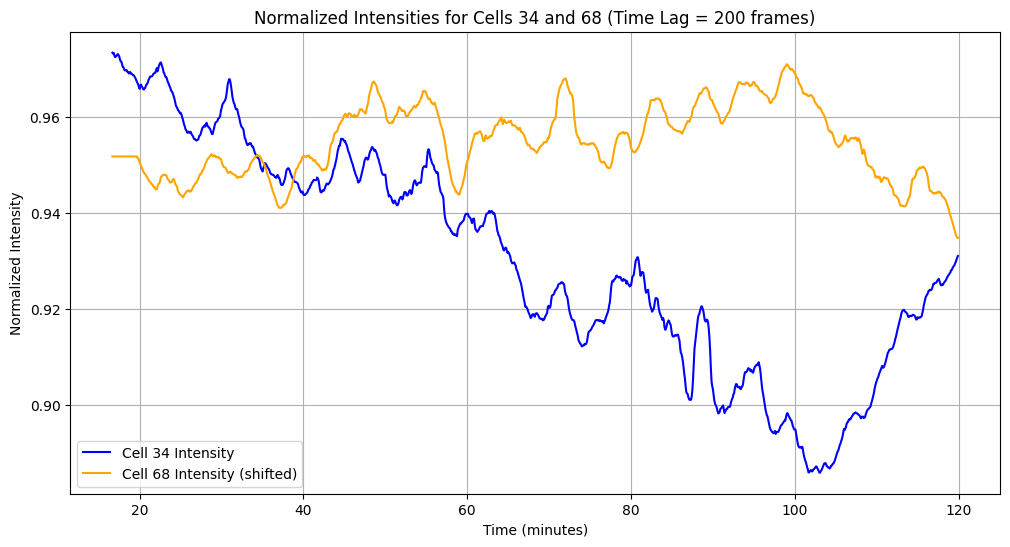

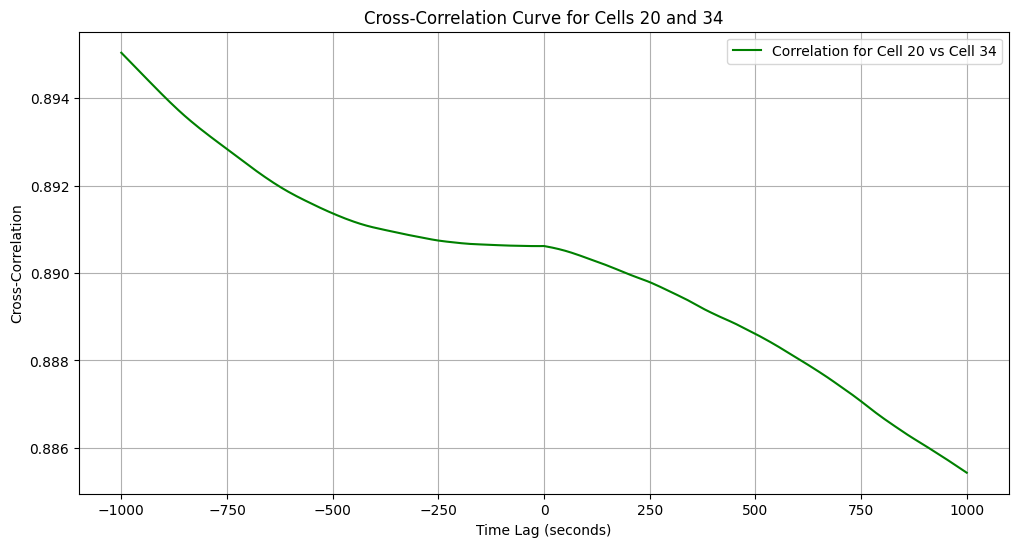

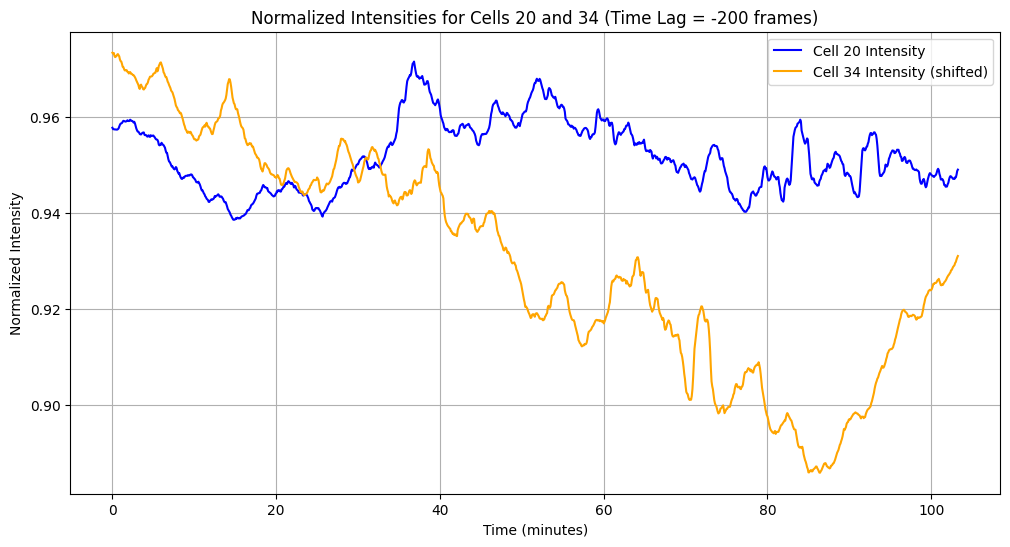

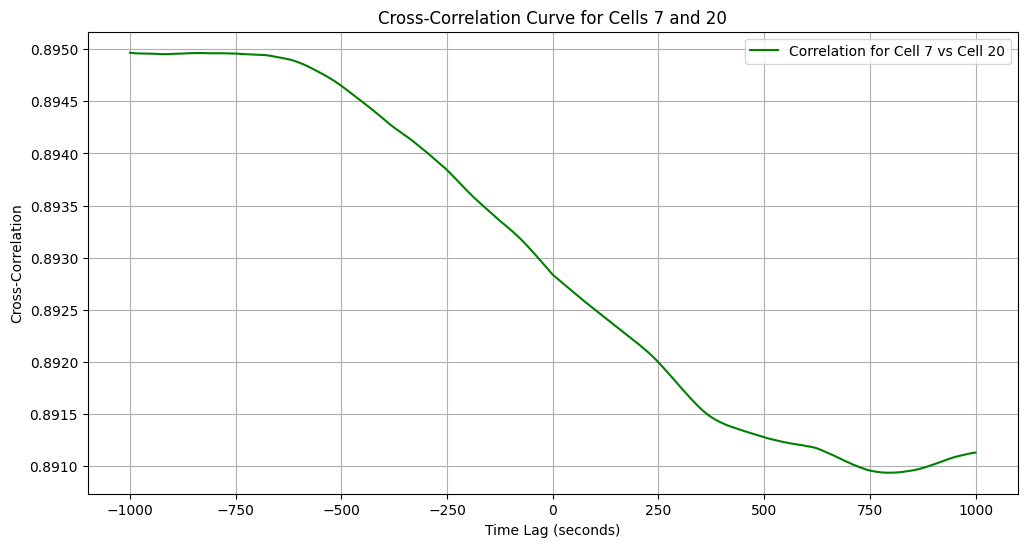

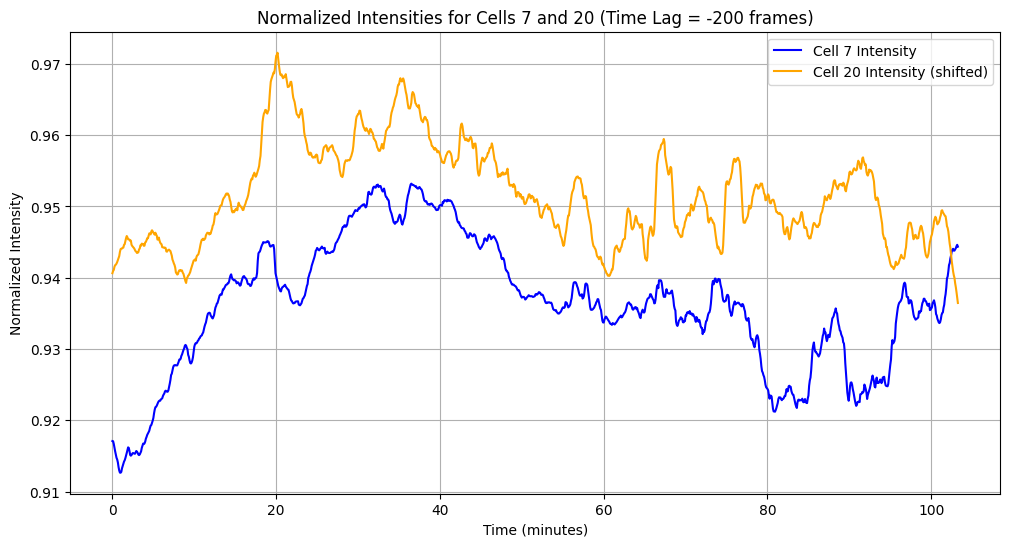

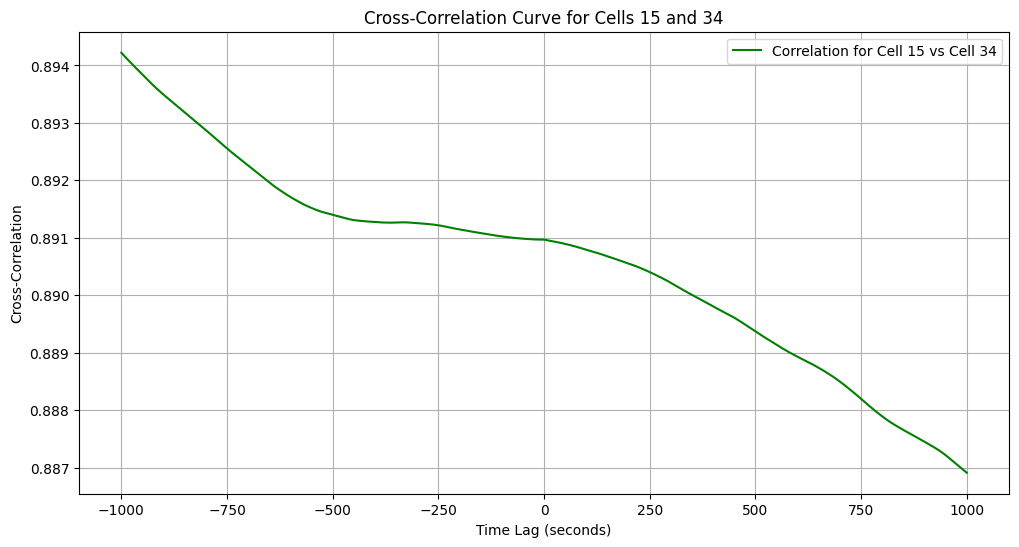

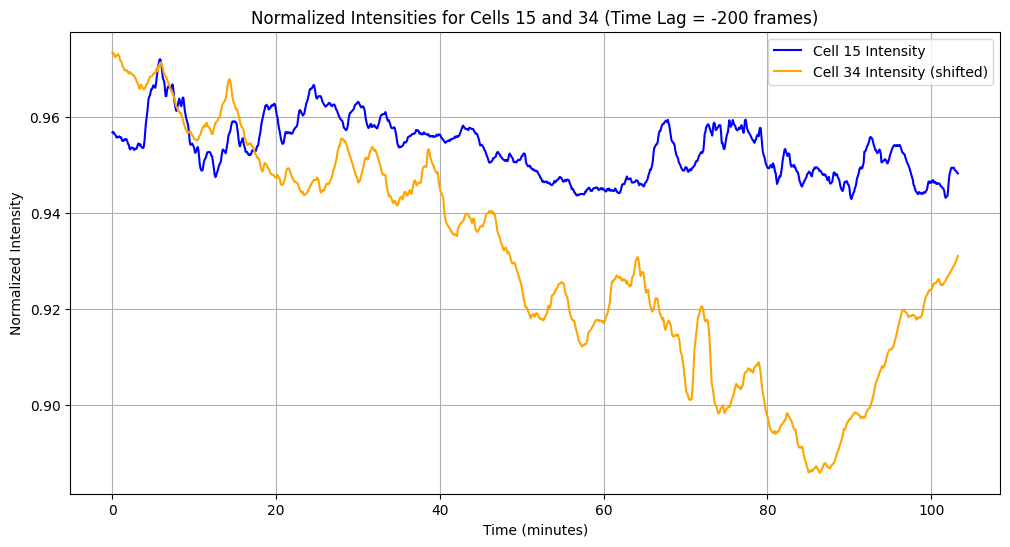

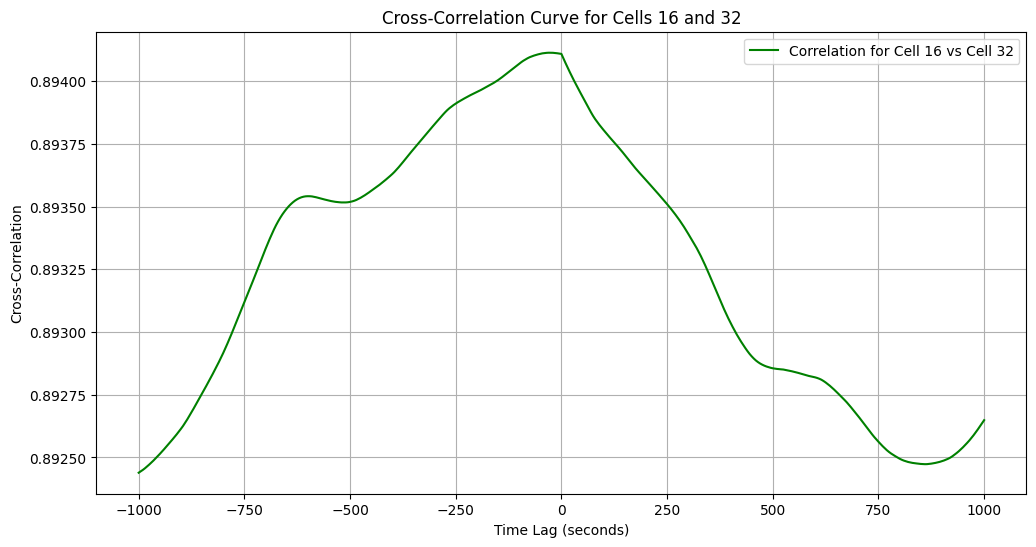

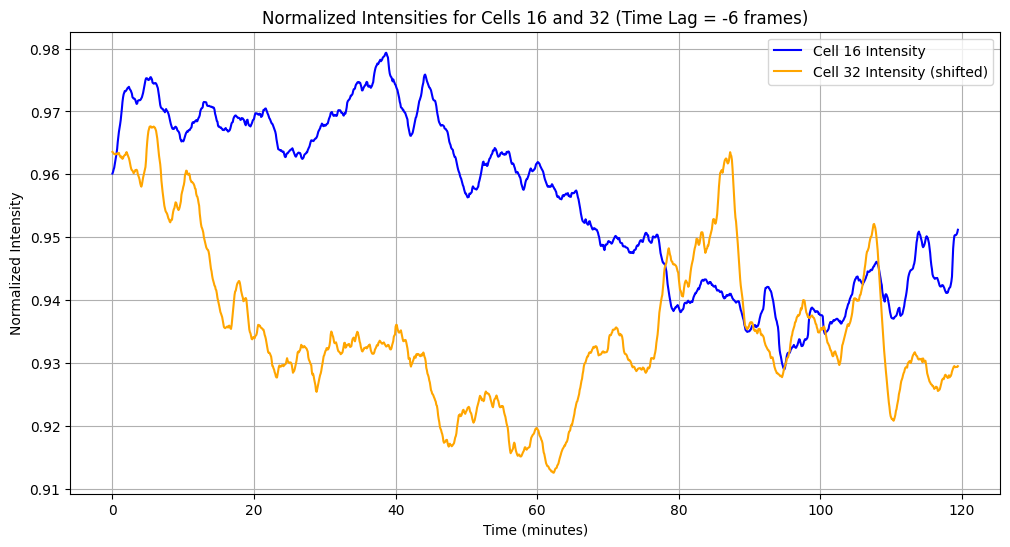

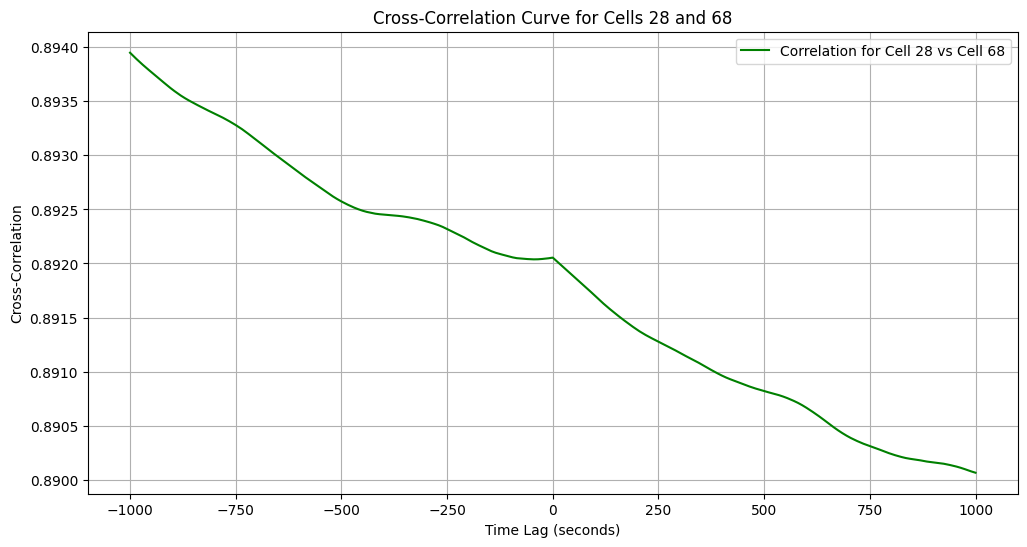

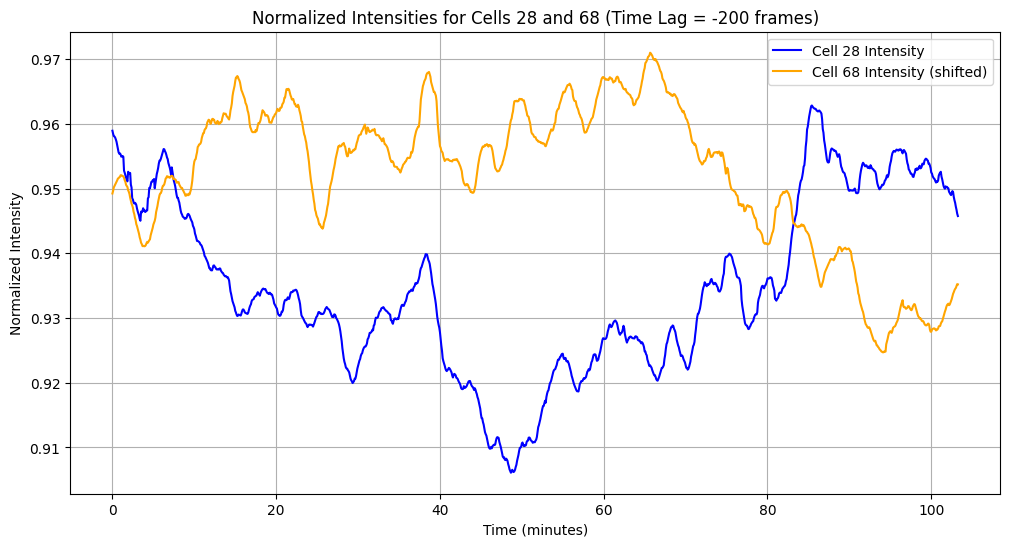

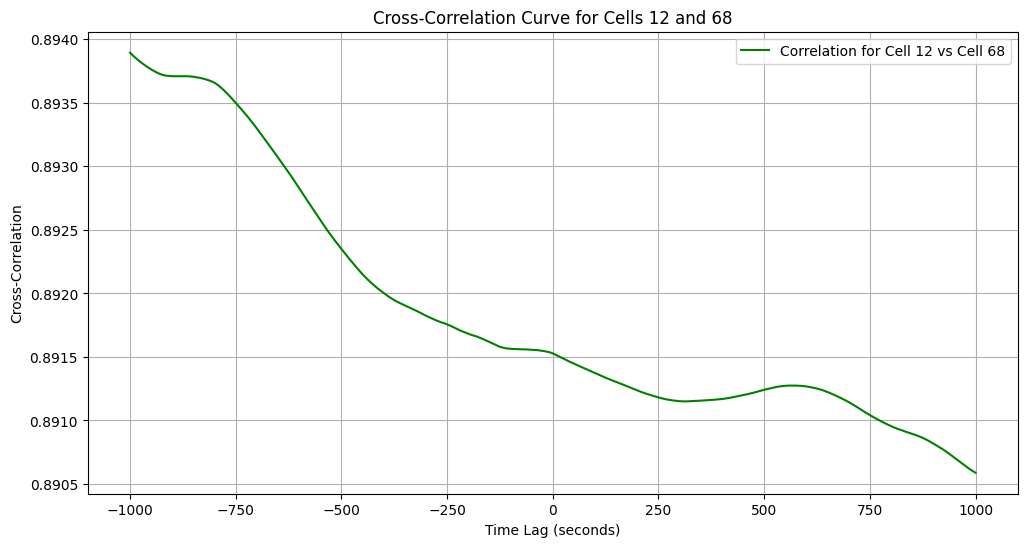

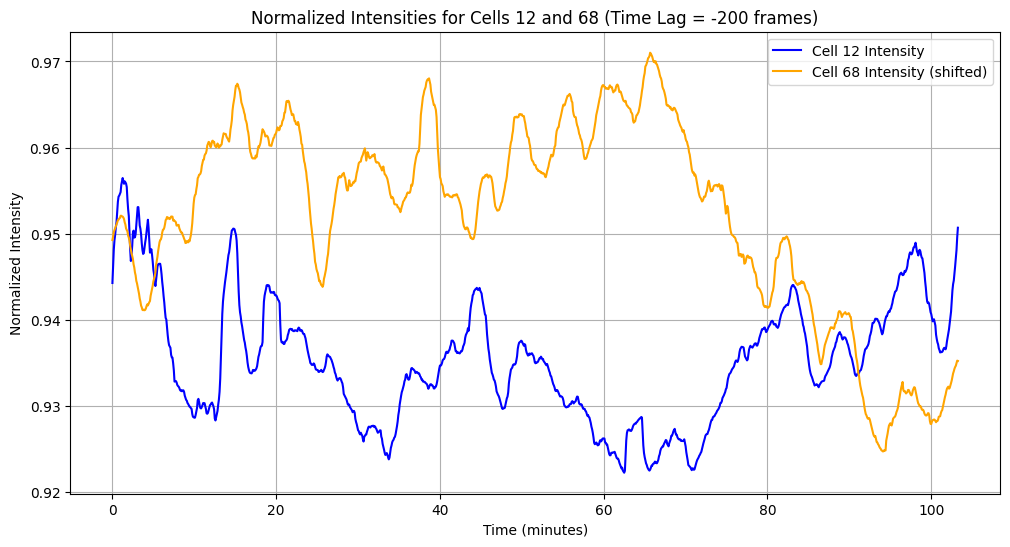

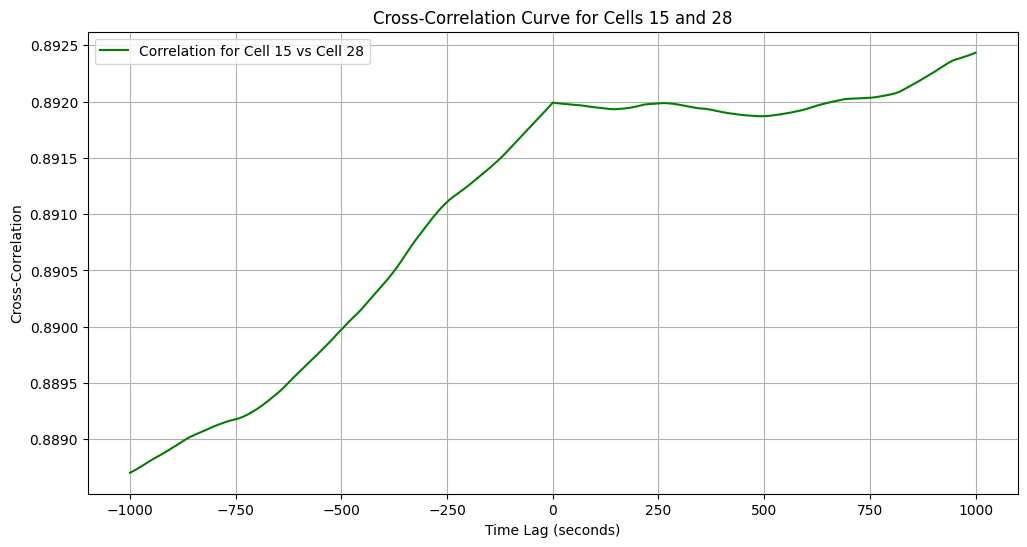

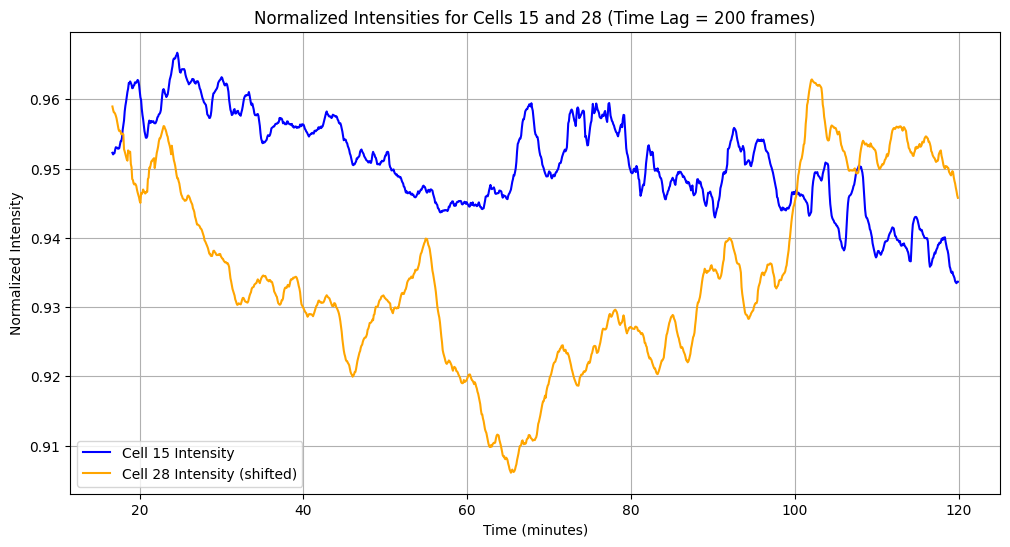

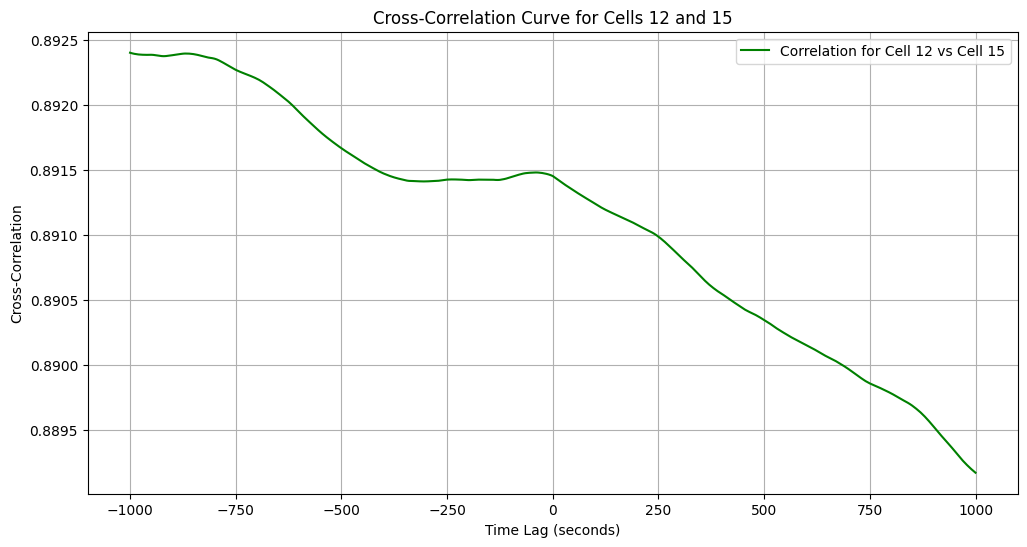

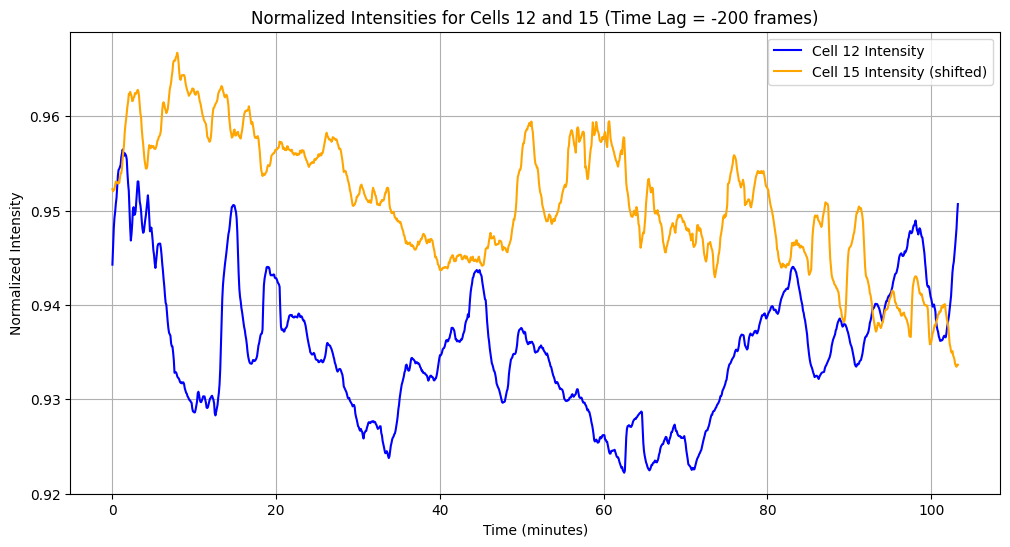

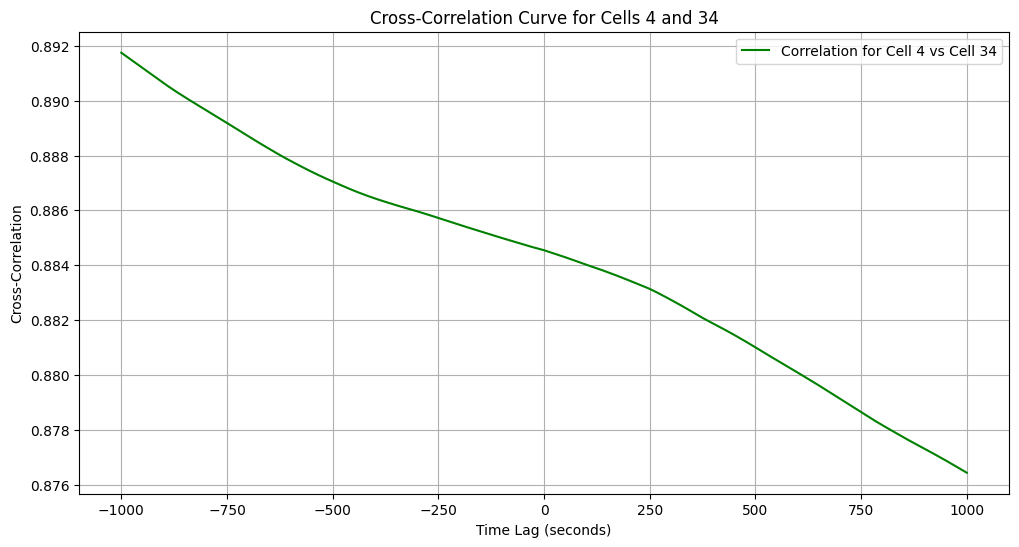

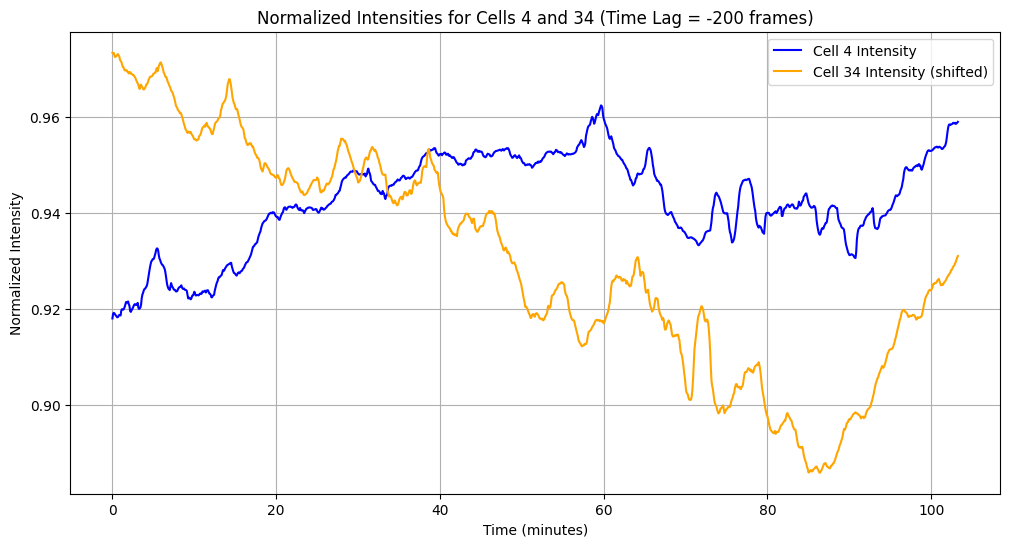

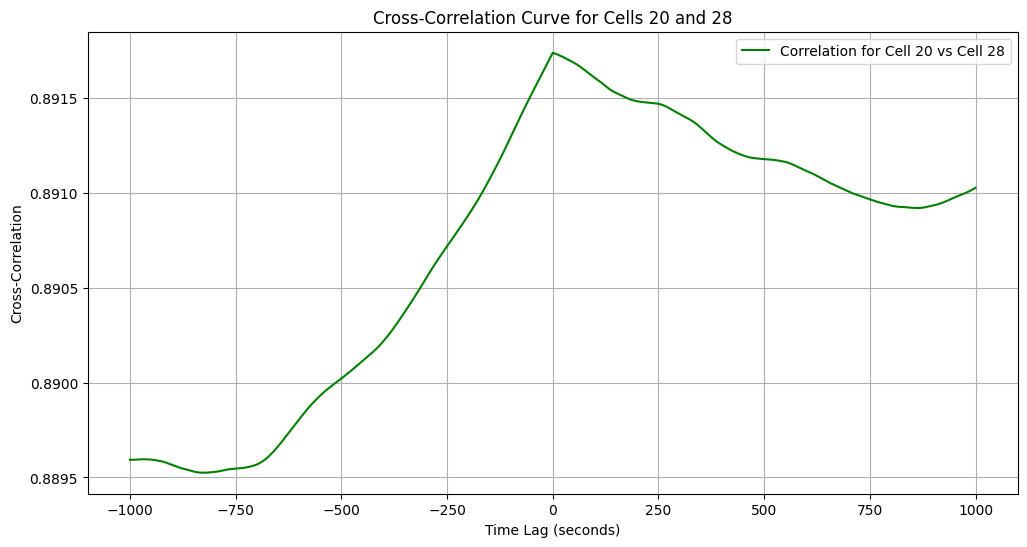

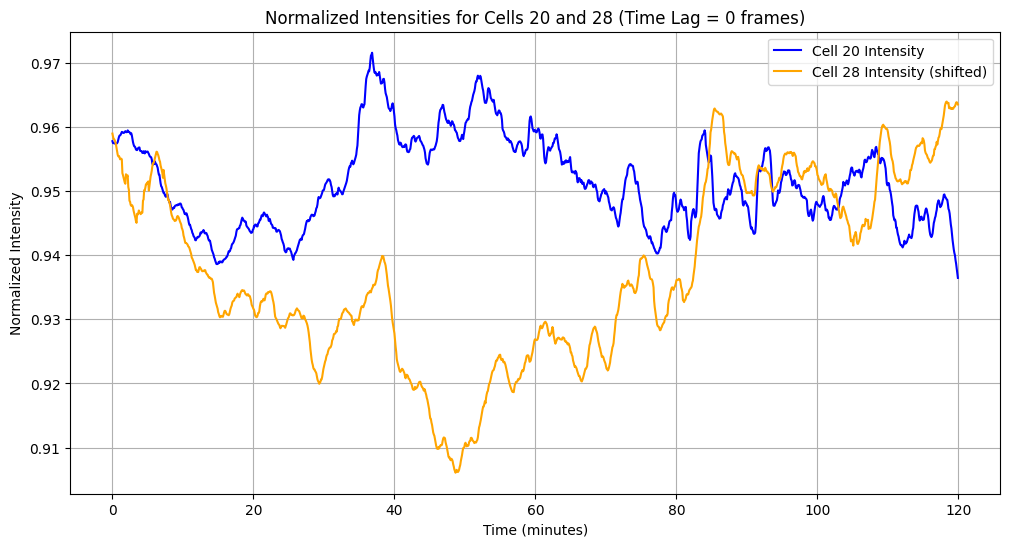

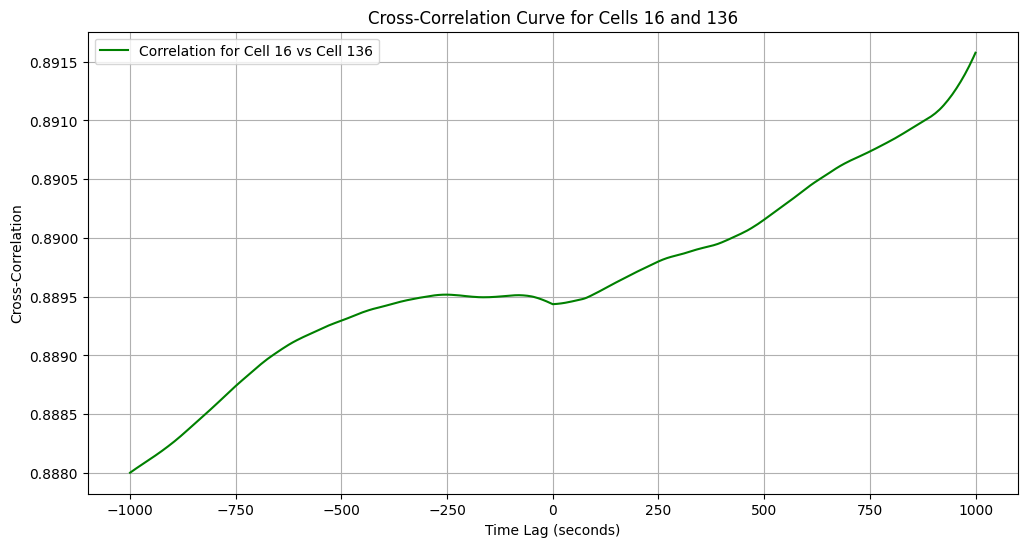

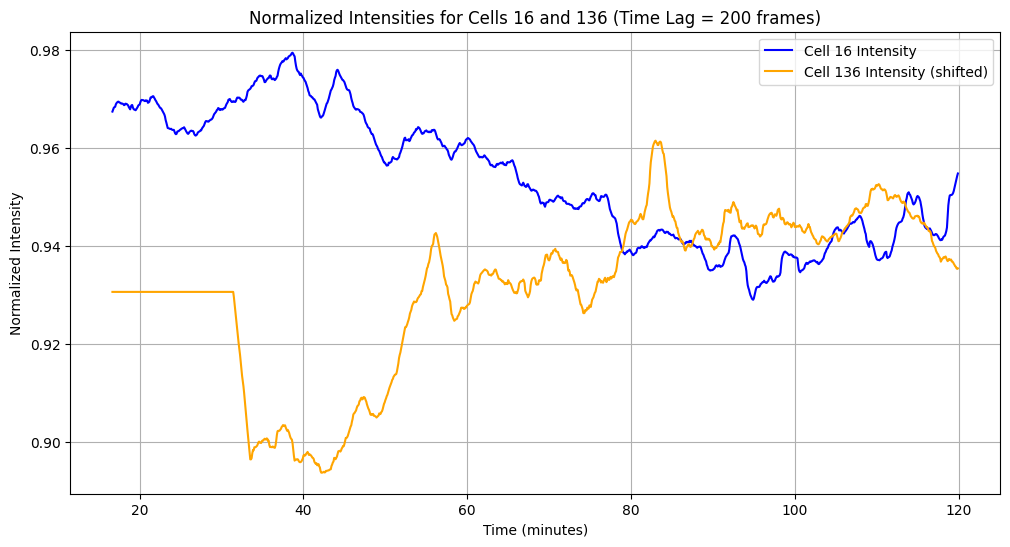

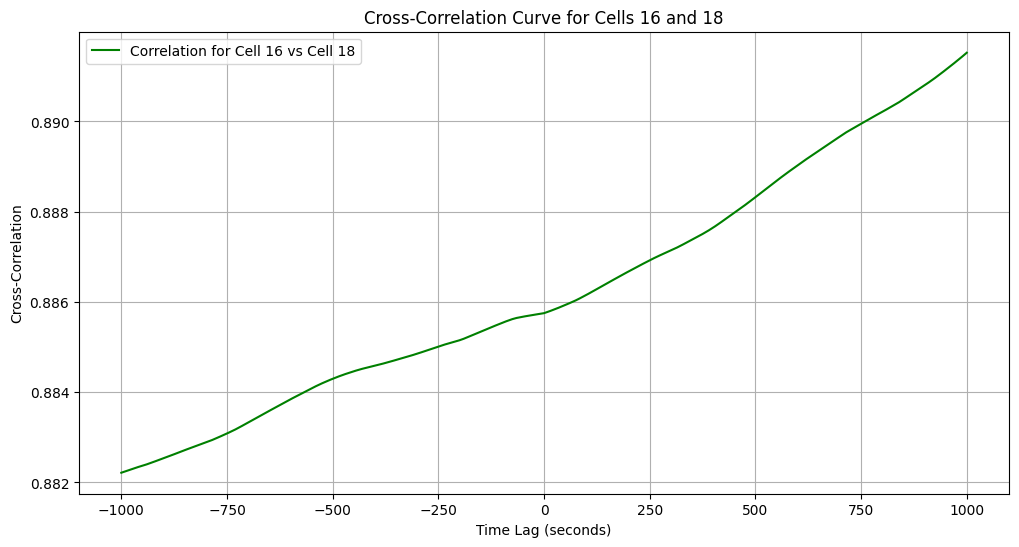

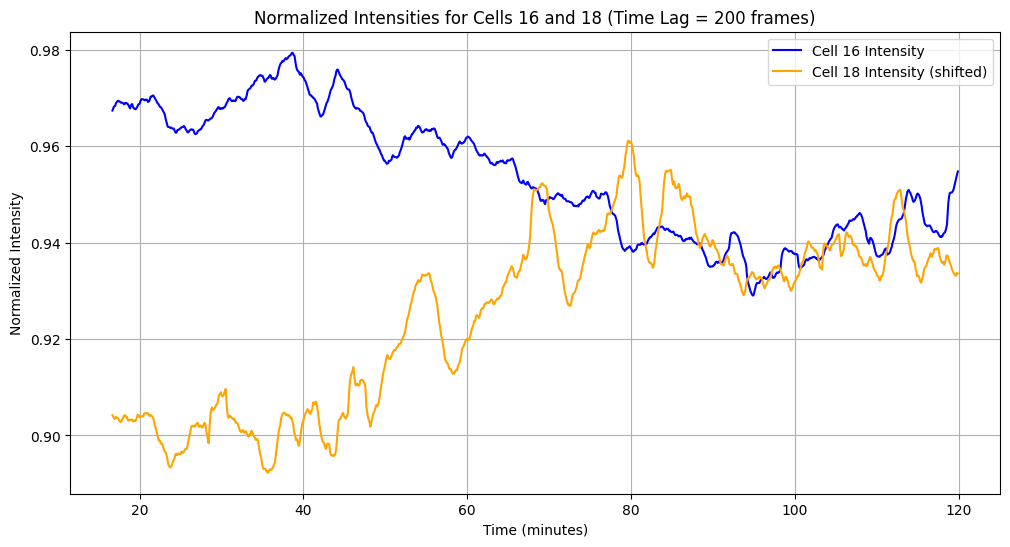

In [11]:
#This section plots the correlation curves and the shifted intensity curves for cell pairs with correlation values above the significant threshold calculated in the previous section.
#The time lag for shifting the intensity curves in relation to each other is determined by the time lag for the maximum correlation value.

threshold = significant_threshold  # Use the significant threshold for filtering 

# Function to shift the intensity curve by the specified time lag
def shift_intensity_curve(intensities, time_lag):
    """Shift the intensity curve by the specified time lag."""
    num_frames = len(intensities)
    shifted_intensity = np.full(num_frames, np.nan)  # Initialize with NaN
    
    if time_lag > 0:  # Shift to the right
        shifted_intensity[time_lag:] = intensities[:-time_lag]
    elif time_lag < 0:  # Shift to the left
        shifted_intensity[:time_lag] = intensities[-time_lag:]
    else:  # No shift
        shifted_intensity = intensities.copy()
    
    return shifted_intensity

# Function to plot the correlation curve
def plot_correlation_curve(correlation_data, frame_rate, cell1, cell2, max_lag):
    """Plot the cross-correlation curve for the given pair of cells."""
    time_lags_in_seconds = correlation_data['time_lags'] * (1 / frame_rate)  # Time in seconds
    plt.figure(figsize=(12, 6))
    plt.plot(time_lags_in_seconds, correlation_data['correlations'], label=f'Correlation for Cell {cell1} vs Cell {cell2}', color='green')
    plt.title(f'Cross-Correlation Curve for Cells {cell1} and {cell2}')
    plt.xlabel('Time Lag (seconds)')
    plt.ylabel('Cross-Correlation')
    plt.grid(True)
    plt.legend()
    plt.show()

# Function to plot the intensity curves with the shifted data
def plot_intensity_curves(cell1, cell2, correlation_data, frame_rate, intensities_filtered):
    """Plot the normalized intensities for two cells, focusing only on overlapping regions."""
    # Retrieve the intensities for both cells
    intensities1 = intensities_filtered[cell1]
    intensities2 = intensities_filtered[cell2]
    
    # Find the time lag corresponding to the maximum correlation
    max_corr_index = np.argmax(correlation_data['correlations'])
    max_time_lag = correlation_data['time_lags'][max_corr_index]
    
    # Shift the second intensity curve by the maximum time lag
    shifted_intensities2 = shift_intensity_curve(intensities2, max_time_lag)
    
    # Calculate the start and end indices for the overlap
    if max_time_lag > 0:
        start_idx = max_time_lag
        end_idx = len(intensities1)
    elif max_time_lag < 0:
        start_idx = 0
        end_idx = len(intensities1) + max_time_lag
    else:
        start_idx = 0
        end_idx = len(intensities1)
    
    # Slice the intensity signals to the overlap region
    valid_intensities1 = intensities1[start_idx:end_idx]
    valid_intensities2 = shifted_intensities2[start_idx:end_idx]
    
    # Create the valid time axis in minutes (only for the overlapping region)
    valid_time_axis = np.arange(start_idx, end_idx) / frame_rate / 60  # Time in minutes
    
    # Plot only the valid overlap region
    plt.figure(figsize=(12, 6))
    plt.plot(valid_time_axis, valid_intensities1, label=f'Cell {cell1} Intensity', color='blue')
    plt.plot(valid_time_axis, valid_intensities2, label=f'Cell {cell2} Intensity (shifted)', color='orange')
    plt.title(f'Normalized Intensities for Cells {cell1} and {cell2} (Time Lag = {max_time_lag} frames)')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Normalized Intensity')
    plt.legend()
    plt.grid(True)
    plt.show()


# Get the list of max correlations above the threshold
correlations_above_threshold = [
    (pair, corr) for pair, corr in max_correlations_filtered if corr > threshold
]

# Sort by the correlation value (descending order)
sorted_correlations_above_threshold = sorted(correlations_above_threshold, key=lambda x: x[1], reverse=True)

# Plotting all pairs with correlations above the threshold
for (cell1, cell2), _ in sorted_correlations_above_threshold:
    # Find the correlation data for the pair of cells
    correlation_data_filtered = next(
        cor_data for (c1, c2), cor_data in all_correlations_filtered if (c1 == cell1 and c2 == cell2) or (c1 == cell2 and c2 == cell1)
    )
    
    # Plot the correlation curve
    plot_correlation_curve(correlation_data_filtered, frame_rate, cell1, cell2, max_lag)
    
    # Plot the intensity curves with overlapping regions only
    plot_intensity_curves(cell1, cell2, correlation_data_filtered, frame_rate, intensities_filtered=filtered_intensities)

In [12]:
# This section finds coordinates for the center of mass for each cell at a specific frame,
# and searches for valid coordinates in neighboring frames if the center of mass is missing or invalid
# It will print a warning if the center of mass is still missing after searching in neighboring frames for a valid coordinate to replace the missing value

#Version 2: Finding COMs for network and non-network cells separately

# This is the frame that will later be used for visualizing the COMs of the filtered cell pairs
frame_to_use = 720  

# You can adjust this value to control how far to search for valid COMs in neighboring frames if some COMs are missing valid coordinates in the chosen frame
max_frame_gap = 250 

threshold = significant_threshold    # Threshold for correlation values to be considered (normalized values between 0 and 1)

# Get the list of max correlations above the threshold
correlations_above_threshold = [
    (pair, corr) for pair, corr in max_correlations_filtered if corr > threshold
]

# Extract the labels from the cell pairs with correlations above the threshold
filtered_pairs = [pair for pair, _ in correlations_above_threshold]
print(f"Filtered pairs (above threshold): {filtered_pairs}")

# Function to extract unique labels from cell pairs
def extract_unique_labels_from_pairs(cell_pairs):
    """Extract unique cell labels from a list of cell pairs."""
    unique_labels = set()
    for pair in cell_pairs:
        unique_labels.add(pair[0])
        unique_labels.add(pair[1])
    return list(unique_labels)

# Extract unique cell labels from the filtered pairs with correlations above the threshold
unique_labels_filtered = extract_unique_labels_from_pairs(filtered_pairs)

# Step 1: Identify non-network cells by excluding those present in the network cells list
# We assume that `tracked_cells` contains all unique cells that are being tracked.
non_network_cells = list(set(tracked_cells) - set(unique_labels_filtered))
print(f"Non-network cells (after exclusion from network labels): {non_network_cells}")

# Function to check if the coordinates of a COM are valid
def is_valid_com(com):
    """Check if a COM is valid (not NaN and not [0, 0])."""
    return not np.isnan(com[0]) and not np.isnan(com[1]) and not np.array_equal(com, [0, 0])

# Function to calculate the center of mass for a given cell at a specific frame
def calculate_center_of_mass_for_cell_at_frame(Y, target_cell, frame_idx):
    """Calculate the center of mass for a given cell label based on a specific frame (frame_idx)."""
    frame_mask = Y[frame_idx]  # Mask for the selected frame

    # Create a binary mask for the target cell (where frame_mask == target_cell)
    binary_mask = (frame_mask == target_cell)

    # If the target cell is present in the frame, calculate its center of mass
    if np.any(binary_mask):
        com = ndimage.center_of_mass(binary_mask)
        if is_valid_com(com):
            return com
    return np.nan, np.nan  # If no valid COM, return NaN

# Function to search for valid COM in neighboring frames and replace missing values
def search_for_valid_com(Y, target_cell, frame_idx, max_frame_gap, direction='both'):
    """Search for a valid COM in neighboring frames based on the specified direction."""
    for gap in range(1, max_frame_gap + 1):
        if direction in ['both', 'forward'] and frame_idx + gap < Y.shape[0]:
            com = calculate_center_of_mass_for_cell_at_frame(Y, target_cell, frame_idx + gap)
            if is_valid_com(com):
                return com

        if direction in ['both', 'backward'] and frame_idx - gap >= 0:
            com = calculate_center_of_mass_for_cell_at_frame(Y, target_cell, frame_idx - gap)
            if is_valid_com(com):
                return com

    # Print a warning if no valid COM is found
    print(f"Warning: No valid COM found for cell {target_cell} at frame {frame_idx} or neighboring frames at maximum distance of {max_frame_gap}.")
    print(f"Try adjusting the maximum frame gap or check the COMs of cell {target_cell} for missing values.")
    return [0, 0]  # If no valid COM is found, return [0, 0]

# Function to calculate the center of mass for a given cell, and search for valid coordinates in neighboring frames if missing
def calculate_valid_center_of_mass(Y, target_cell, frame_idx, max_frame_gap=5):
    """Calculate the center of mass for a cell at the given frame, or search for valid COMs in neighboring frames."""
    com = calculate_center_of_mass_for_cell_at_frame(Y, target_cell, frame_idx)

    # If COM is NaN or [0, 0], search in neighboring frames
    if not is_valid_com(com):
        # Determine the direction to search based on the frame index
        if frame_idx == 0:  # If the frame is the first one, search only forward
            return search_for_valid_com(Y, target_cell, frame_idx, max_frame_gap, direction='forward')
        elif frame_idx == Y.shape[0] - 1:  # If the frame is the last one, search only backward
            return search_for_valid_com(Y, target_cell, frame_idx, max_frame_gap, direction='backward')
        else:  # For other frames, search both forward and backward
            return search_for_valid_com(Y, target_cell, frame_idx, max_frame_gap, direction='both')
    
    return com  # Return the valid COM

# Function to calculate and store the center of mass for each unique cell at a specific frame, using neighboring frames if needed
def calculate_and_save_cell_coms_at_frame(Y, unique_cell_labels, frame_idx, max_frame_gap=5):
    """Calculate and store the center of mass for each unique cell at a specific frame, using neighboring frames if needed."""
    cell_coms = {}
    for target_cell in unique_cell_labels:
        com = calculate_valid_center_of_mass(Y, target_cell, frame_idx, max_frame_gap)
        
        # Ensure the COM is stored as a tuple (x, y)
        if is_valid_com(com):
            cell_coms[target_cell] = tuple(com)  # Store as a tuple (x, y)
    
    return cell_coms

# Calculate and store the center of mass for each unique cell at the specified frame for network cells (above threshold)
filtered_cell_coms_at_frame = calculate_and_save_cell_coms_at_frame(Y, unique_labels_filtered, frame_to_use, max_frame_gap)

# Calculate and store the center of mass for each unique cell at the specified frame for non-network cells (below threshold)
non_network_cell_coms_at_frame = calculate_and_save_cell_coms_at_frame(Y, non_network_cells, frame_to_use, max_frame_gap)

Filtered pairs (above threshold): [(4, 15), (4, 16), (4, 20), (4, 34), (4, 68), (7, 15), (7, 16), (7, 20), (7, 68), (12, 15), (12, 16), (12, 68), (15, 16), (15, 20), (15, 28), (15, 34), (15, 68), (16, 18), (16, 20), (16, 28), (16, 32), (16, 34), (16, 68), (16, 136), (20, 28), (20, 34), (20, 68), (28, 68), (34, 68)]
Non-network cells (after exclusion from network labels): [1, 2, 8, 9, 10, 19, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 36, 37, 38, 71]


Network Cells: {32, 34, 4, 68, 7, 136, 12, 15, 16, 18, 20, 28}
Non-network Cells: [1, 2, 8, 9, 10, 19, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 36, 37, 38, 71]
Filtered COMs: {32: (313.0250941028858, 256.45420326223336), 34: (354.1827242524917, 192.91528239202657), 4: (102.14589665653496, 215.31205673758865), 68: (465.98602287166455, 232.81448538754765), 7: (127.76378772112383, 243.7159209157128), 136: (182.58919803600654, 159.4075286415712), 12: (153.53605769230768, 328.6526442307692), 15: (188.4167585446527, 356.71554575523703), 16: (170.02892561983472, 129.32231404958677), 18: (216.8524374176548, 172.09486166007906), 20: (220.2976098689283, 139.05628373168852), 28: (281.49215922798555, 256.19179734620025)}
Non-network Coordinates: [(67.0684500393391, 246.9181746656176), (77.89599236641222, 318.90935114503816), (133.24619640387274, 354.2572614107884), (135.73781291172597, 187.04347826086956), (154.98605830164766, 206.82636248415716), (207.07874260815439, 322.04046062869594), (223.9640

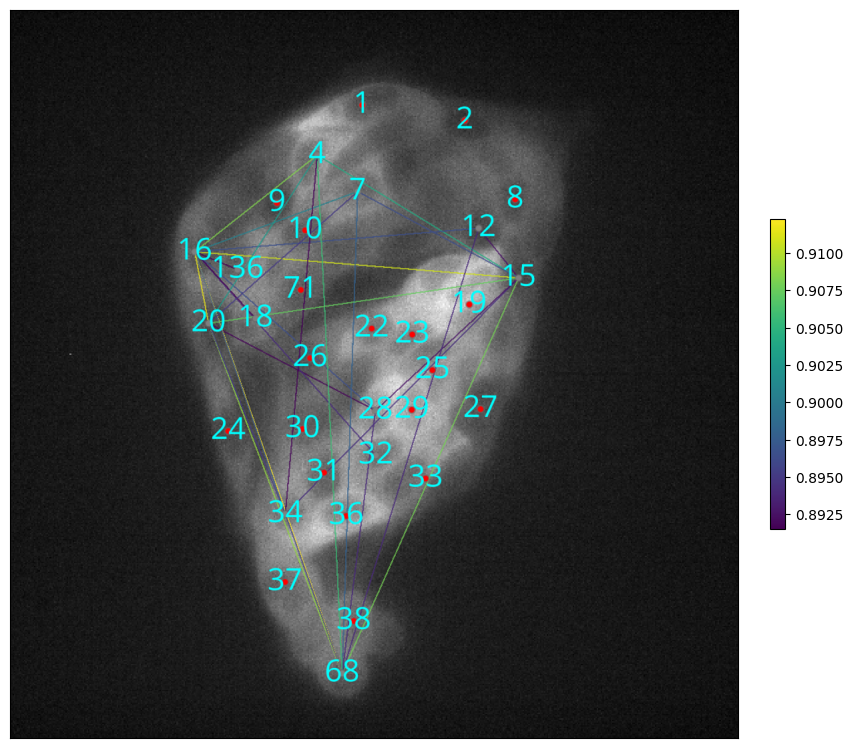

In [15]:
#This section creates the Napari image of the network of cell correlations and the COMs of the tracked cells at a specific frame and saves them to the path specified in the export_path variable
#under the name specified in the plot_name variable

def plot_network_and_cell_coms_in_napari(X, correlations_above_threshold, filtered_cell_comms, non_network_cell_comms_at_frame, frame_idx, export_path=None):
    """
    Plot the network of cell connections and the average center of mass (COM) of tracked cells in Napari for a given frame.
    This uses the precomputed `correlations_above_threshold` to fetch the filtered correlation for each pair.
    
    Parameters:
    - correlations_above_threshold: List of tuples, where each tuple contains a pair of cell IDs and their corresponding correlation value.
    - tracked_cells: List of all tracked cell labels (both with and without significant correlations).
    - frame_idx: The index of the frame to plot (only this frame's COMs will be displayed).
    - export_path: Optional path to save the screenshot of the Napari viewer.
    """
    
    # Initialize the Napari viewer
    viewer = napari.Viewer()

    # Step 1: Add the chosen frame's image (from X) to the Napari viewer
    viewer.add_image(X[frame_idx], name=f'Frame {frame_idx}', blending='additive')

    # Step 2: Prepare data for plotting
    network_cells = set()  # Cells with correlations above threshold
    edges = []  # Store edges between cells
    edge_colors = []  # Store correlation values for colormap

    # Step 3: Process the filtered pairs from `correlations_above_threshold`
    for (pair, correlation_value) in correlations_above_threshold:
        cell1, cell2 = pair

        # Check if both cells have valid COM data for the chosen frame
        if cell1 in filtered_cell_comms and cell2 in filtered_cell_comms:
            com1 = filtered_cell_comms[cell1]
            com2 = filtered_cell_comms[cell2]

            # Add the pair to the list of edges for plotting
            edges.append([com1, com2])
            network_cells.add(cell1)
            network_cells.add(cell2)
        
            # Add correlation value to edge_colors
            edge_colors.append(float(correlation_value))  # Ensure it's numeric

    # Debugging: Print out network and non-network cells
    print(f"Network Cells: {network_cells}")
    print(f"Non-network Cells: {non_network_cells}")

    # Step 4: Normalize the correlation colors
    if edge_colors:
        norm = colors.Normalize(vmin=min(edge_colors), vmax=max(edge_colors))
        colormap = cm.viridis  # Get the 'viridis' colormap from matplotlib
        edge_colors_rgb = [colormap(norm(corr))[:3] for corr in edge_colors]  # Map raw correlation values to RGB
    
    # Step 5: Plot the edges (network) in Napari with color based on the filtered correlation
    edge_lines = []
    for edge in edges:
        com1, com2 = edge
        if not np.any(np.isnan(com1)) and not np.any(np.isnan(com2)):
            edge_lines.append([[com1[0], com1[1]], [com2[0], com2[1]]])  # Each edge has two points

    if edge_lines:
        shapes_layer = viewer.add_shapes(edge_lines, shape_type='line', edge_color=edge_colors_rgb, edge_width=1, name='Cell Network')

    # Step 6: Plot the valid COM coordinates for the cells with correlations above threshold (as points)
    avg_coords = []
    labels = []

    for cell_id in network_cells:  # Only consider cells in the filtered network
        if cell_id in filtered_cell_comms:  # Only consider cells that have valid COMs
            avg_x, avg_y = filtered_cell_comms[cell_id]
            avg_coords.append([avg_x, avg_y])
            labels.append(str(cell_id))  # Labels as strings

    if avg_coords:  # Only plot if there are valid coordinates
        points_layer = viewer.add_points(avg_coords, size=5, face_color='grey', name='Filtered Cell COMs', text=labels)

        # Change the color of the text labels to white
        points_layer.text_color = 'white'
    else:
        print("No valid COMs found for the selected frame.")

    # Step 7: Plot the valid COM coordinates for the cells with correlations below threshold (as points)
    non_network_coords = []
    non_network_labels = []

    # Debugging: Check non-network cells' positions
    print(f"Filtered COMs: {filtered_cell_comms}")
    
    for cell_id in non_network_cell_comms_at_frame:  # Only consider cells with correlations below threshold
        if cell_id in non_network_cell_comms_at_frame:  # Only consider cells that have valid COMs
            avg_x, avg_y = non_network_cell_comms_at_frame[cell_id]
            non_network_coords.append((avg_x, avg_y))  # Ensure coordinates are tuples
            non_network_labels.append(str(cell_id))  # Labels as strings
        else:
            print(f"Missing COM for cell {cell_id}")  # Debugging missing cells

    print(f"Non-network Coordinates: {non_network_coords}")

    if non_network_coords:  # Only plot if there are valid coordinates
        non_network_points_layer = viewer.add_points(non_network_coords, size=5, face_color='red', name='Non-network Cell COMs', text=non_network_labels)

        # Change the color of the text labels to white
        non_network_points_layer.text_color = 'white'

    # Step 8: Capture the screenshot of the viewer
    if export_path:
        screenshot = viewer.screenshot()
        
        # Convert screenshot (which is in numpy array) to an image (PIL)
        image = Image.fromarray(screenshot)

        # Crop the image to remove any surrounding black (background) region
        gray_image = image.convert("L")
        bbox = gray_image.getbbox()  # Get the bounding box of the non-black areas

        # Crop the image based on the bounding box
        cropped_image = image.crop(bbox)

        # Save the cropped image using the pre-defined plot_file_path
        cropped_image.save(plot_file_path, format="PNG")  # Save the cropped image

    # Step 9: Start the Napari viewer
    napari.run()  # Ensure viewer remains open for interaction

    # Step 10: Create the final matplotlib plot and overwrite the cropped image
    if export_path:
        # Create a new figure in matplotlib for the combined plot
        fig, ax = plt.subplots(figsize=(10, 10))

        # Display the Napari screenshot directly
        image_data = plt.imread(plot_file_path)  # Read the image saved by Napari
        ax.imshow(image_data)

        # Remove the ticks from both x and y axes
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_yticks([])  # Remove y-axis ticks

        # Create a colorbar for the plot based on edge colors, if there are edges
        if edge_colors:
            sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
            sm.set_array([])  # Empty array for the colorbar
            plt.colorbar(sm, ax=ax, fraction=0.02, pad=0.04)

        # Save the final plot to a file (this will overwrite the previously saved image)
        final_export_path = plot_file_path  # Use the same export path as the cropped image
        plt.savefig(final_export_path)

        # Display the plot in the IDE output
        plt.show()

        # Close the figure after displaying
        plt.close(fig)

# Ensure the plot path is set correctly and passed into the function
plot_network_and_cell_coms_in_napari(X, correlations_above_threshold, filtered_cell_coms_at_frame, non_network_cell_coms_at_frame, frame_idx=frame_to_use, export_path=export_path)
